# ノートブック17: Titanic Top 30%達成 - 実践Kaggle完全ガイド 🏆

**学習目標**: Kaggle TitanicコンペティションでTop 30%（Public LB 0.79+）を達成

---

## 📋 このノートブックで学ぶこと

### 1. 高度な特徴量エンジニアリング ⭐⭐⭐
- Ticket prefix extraction（チケット番号から階級を推定）
- Cabin deck analysis（客室デッキ情報の活用）
- Title extraction（敬称の抽出と分類）
- Age imputation（機械学習による年齢補完）
- Feature interactions（特徴量の交互作用）

### 2. Optunaによる自動最適化 ⭐⭐⭐
- Bayesian Optimizationの実践
- LightGBM、XGBoost、CatBoostの最適化
- CVスコアを最大化するパラメータ探索

### 3. 堅牢な検証戦略 ⭐⭐
- 10-Fold Stratified Cross-Validation
- Out-of-fold predictions
- CV Score vs LB Scoreの関係理解

### 4. アンサンブル戦略 ⭐⭐⭐
- LightGBM + XGBoost + CatBoostの重み付き平均
- Blending vs Stacking
- Calibration（確率調整）

### 5. Kaggle提出戦略 ⭐
- Multiple submissions
- Leaderboard probing
- Score variance analysis

---

## 🎯 目標スコア

- **Local CV**: 0.85+
- **Public LB**: 0.79+ (Top 30%)

---

## 📚 前提知識

このノートブックを始める前に、以下を完了していることを推奨：
- ノートブック13-16（GBDT基礎）
- 基本的なPandas、NumPy、Matplotlib
- LightGBM、XGBoost、CatBoostの基本操作

---

## ⚠️ 重要な注意事項

1. **データの配置**: Kaggleから`train.csv`と`test.csv`をダウンロードし、`../data/titanic/`に配置してください
2. **計算時間**: Optunaの最適化は時間がかかります（約30-60分）
3. **再現性**: `random_state`を固定していますが、環境により若干の差が出る可能性があります

---

## 🔧 1. セットアップ

必要なライブラリをインポートし、環境を準備します。

In [1]:
# 基本ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

# 機械学習ライブラリ
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# GBDT
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# ハイパーパラメータ最適化
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# 設定
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# 再現性のためのシード固定
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ ライブラリのインポート完了")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"LightGBM version: {lgb.__version__}")
print(f"XGBoost version: {xgb.__version__}")
print(f"Optuna version: {optuna.__version__}")

✅ ライブラリのインポート完了
NumPy version: 2.3.5
Pandas version: 2.3.3
LightGBM version: 4.6.0
XGBoost version: 3.1.2
Optuna version: 4.6.0


## 📊 2. データ読み込み

Kaggle Titanicデータセットを読み込みます。

In [2]:
# データディレクトリの作成（存在しない場合）
data_dir = Path('../data/titanic')
data_dir.mkdir(parents=True, exist_ok=True)

# データ読み込み
try:
    train = pd.read_csv(data_dir / 'train.csv')
    test = pd.read_csv(data_dir / 'test.csv')
    print("✅ データ読み込み成功")
except FileNotFoundError:
    print("⚠️ データが見つかりません。以下の手順でデータを準備してください：")
    print("1. https://www.kaggle.com/c/titanic/data にアクセス")
    print("2. train.csv と test.csv をダウンロード")
    print(f"3. {data_dir} に配置")
    # デモ用のダミーデータを作成（実際にはKaggleからダウンロード必要）
    print("\n⚠️ デモ用のダミーデータを作成します（実際のKaggle提出には使用できません）")
    from sklearn.datasets import make_classification
    X, y = make_classification(n_samples=891, n_features=10, n_informative=7, 
                                n_redundant=2, random_state=42)
    train = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(10)])
    train['Survived'] = y
    train['PassengerId'] = range(1, 892)
    test = pd.DataFrame(X[:418], columns=[f'feature_{i}' for i in range(10)])
    test['PassengerId'] = range(892, 1310)

print(f"\n📊 データセット情報:")
print(f"- Train shape: {train.shape}")
print(f"- Test shape: {test.shape}")
print(f"\n最初の5行:")
display(train.head())

# ターゲット分布
if 'Survived' in train.columns:
    print(f"\n🎯 生存率: {train['Survived'].mean():.2%}")
    print(train['Survived'].value_counts())

⚠️ データが見つかりません。以下の手順でデータを準備してください：
1. https://www.kaggle.com/c/titanic/data にアクセス
2. train.csv と test.csv をダウンロード
3. ../data/titanic に配置

⚠️ デモ用のダミーデータを作成します（実際のKaggle提出には使用できません）

📊 データセット情報:
- Train shape: (891, 12)
- Test shape: (418, 11)

最初の5行:


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,Survived,PassengerId
0,-1.893867,1.229047,-0.230242,-1.908203,1.769132,-1.376831,-0.541408,-1.672698,-0.563731,0.358867,1,1
1,-0.780755,0.253774,1.412598,-1.192147,0.287663,-0.383883,-2.568019,0.627978,1.553431,2.737255,1,2
2,-0.010589,-1.159002,3.465057,-1.035897,2.434476,-0.910296,-4.286881,0.053156,1.782999,4.453971,0,3
3,-1.916063,-0.754361,2.347053,-0.317867,1.573968,0.581273,-0.943262,-1.411736,-0.109916,3.580954,0,4
4,0.217657,-0.987505,2.671005,0.072282,0.633572,-1.009745,-0.807712,1.343523,-0.644147,1.248575,0,5



🎯 生存率: 50.28%
Survived
1    448
0    443
Name: count, dtype: int64


## 🔨 3. 高度な特徴量エンジニアリング

Top 30%を達成するための高度な特徴量を作成します。

In [3]:
def advanced_feature_engineering(df, is_train=True):
    """
    高度な特徴量エンジニアリング
    
    Parameters:
    -----------
    df : pd.DataFrame
        入力データ
    is_train : bool
        訓練データかどうか
    
    Returns:
    --------
    pd.DataFrame : 特徴量を追加したデータフレーム
    """
    df = df.copy()
    
    # 1. Title（敬称）の抽出 ⭐⭐⭐
    if 'Name' in df.columns:
        df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
        
        # レアなタイトルをグループ化
        title_mapping = {
            'Mr': 'Mr',
            'Miss': 'Miss',
            'Mrs': 'Mrs',
            'Master': 'Master',
            'Rev': 'Rare',
            'Dr': 'Rare',
            'Col': 'Rare',
            'Major': 'Rare',
            'Mlle': 'Miss',
            'Countess': 'Rare',
            'Ms': 'Miss',
            'Lady': 'Rare',
            'Jonkheer': 'Rare',
            'Don': 'Rare',
            'Dona': 'Rare',
            'Mme': 'Mrs',
            'Capt': 'Rare',
            'Sir': 'Rare'
        }
        df['Title'] = df['Title'].map(title_mapping)
        df['Title'] = df['Title'].fillna('Rare')
    
    # 2. Family Size（家族サイズ） ⭐⭐
    if 'SibSp' in df.columns and 'Parch' in df.columns:
        df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
        df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
        
        # 家族サイズのカテゴリ化
        df['FamilySizeGroup'] = pd.cut(df['FamilySize'], 
                                        bins=[0, 1, 4, 20], 
                                        labels=['Alone', 'Small', 'Large'])
    
    # 3. Cabin Deck（デッキ情報） ⭐⭐⭐
    if 'Cabin' in df.columns:
        df['Deck'] = df['Cabin'].str[0]
        df['Deck'] = df['Deck'].fillna('Unknown')
        df['HasCabin'] = df['Cabin'].notna().astype(int)
        
        # 客室番号（存在する場合）
        df['CabinNumber'] = df['Cabin'].str.extract('([0-9]+)', expand=False)
        df['CabinNumber'] = pd.to_numeric(df['CabinNumber'], errors='coerce')
    
    # 4. Ticket prefix（チケット接頭辞） ⭐⭐
    if 'Ticket' in df.columns:
        df['TicketPrefix'] = df['Ticket'].str.split(' ').str[0]
        df['TicketPrefix'] = df['TicketPrefix'].str.replace('[^A-Za-z]', '', regex=True)
        df['TicketPrefix'] = df['TicketPrefix'].replace('', 'None')
        
        # チケット番号の長さ
        df['TicketLength'] = df['Ticket'].apply(lambda x: len(str(x)))
    
    # 5. Fare per person（1人あたりの運賃） ⭐⭐
    if 'Fare' in df.columns and 'FamilySize' in df.columns:
        df['FarePerPerson'] = df['Fare'] / df['FamilySize']
        
        # Fare のビニング
        df['FareBin'] = pd.qcut(df['Fare'].fillna(df['Fare'].median()), 
                                 q=5, labels=False, duplicates='drop')
    
    # 6. Age binning（年齢のビニング） ⭐⭐
    if 'Age' in df.columns:
        df['AgeBin'] = pd.cut(df['Age'].fillna(df['Age'].median()), 
                               bins=[0, 12, 18, 35, 60, 100], 
                               labels=['Child', 'Teen', 'Adult', 'MiddleAge', 'Senior'])
    
    # 7. Name length（名前の長さ） ⭐
    if 'Name' in df.columns:
        df['NameLength'] = df['Name'].apply(len)
    
    # 8. 交互作用特徴量 ⭐⭐⭐
    if 'Sex' in df.columns and 'Pclass' in df.columns:
        df['Sex_Pclass'] = df['Sex'].astype(str) + '_' + df['Pclass'].astype(str)
    
    if 'Age' in df.columns and 'Pclass' in df.columns:
        df['Age_Pclass'] = df['Age'].fillna(df['Age'].median()) * df['Pclass']
    
    # 9. Embarked（乗船港）の処理 ⭐
    if 'Embarked' in df.columns:
        df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    
    print(f"✅ 特徴量エンジニアリング完了")
    print(f"   作成された特徴量数: {df.shape[1]}")
    
    return df

# 特徴量エンジニアリングの適用
train_fe = advanced_feature_engineering(train, is_train=True)
test_fe = advanced_feature_engineering(test, is_train=False)

print(f"\n📊 特徴量エンジニアリング後のshape:")
print(f"Train: {train_fe.shape}")
print(f"Test: {test_fe.shape}")
print(f"\n新しい特徴量:")
new_features = set(train_fe.columns) - set(train.columns)
for feat in sorted(new_features):
    print(f"  - {feat}")

✅ 特徴量エンジニアリング完了
   作成された特徴量数: 12
✅ 特徴量エンジニアリング完了
   作成された特徴量数: 11

📊 特徴量エンジニアリング後のshape:
Train: (891, 12)
Test: (418, 11)

新しい特徴量:


### 3.1 Age Imputation（機械学習による年齢補完） ⭐⭐⭐

欠損している年齢を他の特徴量から予測します。

In [4]:
def impute_age_ml(train_df, test_df):
    """
    Random Forestで年齢を補完
    """
    # 結合してまとめて処理
    combined = pd.concat([train_df, test_df], ignore_index=True, sort=False)
    
    # Age予測に使う特徴量
    age_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title']
    
    # カテゴリカル変数のエンコーディング
    for col in ['Sex', 'Embarked', 'Title']:
        if col in combined.columns:
            le = LabelEncoder()
            combined[col + '_encoded'] = le.fit_transform(combined[col].astype(str))
            age_features[age_features.index(col)] = col + '_encoded'
    
    # 欠損していないデータで学習
    known_age = combined[combined['Age'].notna()].copy()
    unknown_age = combined[combined['Age'].isna()].copy()
    
    if len(unknown_age) > 0:
        X_train = known_age[age_features].fillna(0)
        y_train = known_age['Age']
        X_test = unknown_age[age_features].fillna(0)
        
        # Random Forestで予測
        rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
        rf.fit(X_train, y_train)
        
        predicted_ages = rf.predict(X_test)
        combined.loc[combined['Age'].isna(), 'Age'] = predicted_ages
        
        print(f"✅ {len(unknown_age)}件の年齢を補完しました")
    
    # 分割して返す
    train_len = len(train_df)
    return combined.iloc[:train_len].copy(), combined.iloc[train_len:].copy()

# 年齢補完の実行
if 'Age' in train_fe.columns:
    print(f"補完前の欠損数: {train_fe['Age'].isna().sum()}")
    train_fe, test_fe = impute_age_ml(train_fe, test_fe)
    print(f"補完後の欠損数: {train_fe['Age'].isna().sum()}")

## 🎯 4. データ前処理

モデル学習のためにデータを準備します。

In [5]:
def prepare_data(train_df, test_df):
    """
    モデル学習用にデータを準備
    """
    # 使用しない列
    drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']
    if 'Survived' in train_df.columns:
        drop_cols.append('Survived')
    
    # 特徴量とターゲットの分離
    X = train_df.drop(columns=[col for col in drop_cols if col in train_df.columns])
    y = train_df['Survived'] if 'Survived' in train_df.columns else None
    X_test = test_df.drop(columns=[col for col in drop_cols if col in test_df.columns])
    
    # カテゴリカル変数の処理
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    
    for col in categorical_cols:
        # Label Encoding
        le = LabelEncoder()
        
        # train と test を結合してfitすることで、一貫性を保つ
        combined = pd.concat([X[col], X_test[col]], ignore_index=True)
        le.fit(combined.astype(str))
        
        X[col] = le.transform(X[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))
    
    # 残った欠損値を中央値で補完
    X = X.fillna(X.median())
    X_test = X_test.fillna(X_test.median())
    
    print(f"✅ データ準備完了")
    print(f"   特徴量数: {X.shape[1]}")
    print(f"   訓練データ: {X.shape[0]} samples")
    print(f"   テストデータ: {X_test.shape[0]} samples")
    
    return X, y, X_test

# データ準備
X, y, X_test = prepare_data(train_fe, test_fe)

print(f"\n📊 特徴量一覧:")
for i, col in enumerate(X.columns, 1):
    print(f"{i:2d}. {col}")

✅ データ準備完了
   特徴量数: 10
   訓練データ: 891 samples
   テストデータ: 418 samples

📊 特徴量一覧:
 1. feature_0
 2. feature_1
 3. feature_2
 4. feature_3
 5. feature_4
 6. feature_5
 7. feature_6
 8. feature_7
 9. feature_8
10. feature_9


## 🚀 5. Optunaによるハイパーパラメータ最適化

LightGBM、XGBoost、CatBoostの最適なパラメータを探索します。

### 5.1 LightGBM最適化

In [6]:
def objective_lgb(trial):
    """
    LightGBMのOptuna objective関数
    """
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': RANDOM_STATE,
        
        # Optunaで最適化するパラメータ
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }
    
    # Stratified K-Fold CV
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = []
    
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train, 
                 eval_set=[(X_val, y_val)],
                 callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)])
        
        preds = model.predict(X_val)
        score = accuracy_score(y_val, preds)
        cv_scores.append(score)
    
    return np.mean(cv_scores)

# LightGBM最適化の実行
print("🔍 LightGBMのハイパーパラメータ最適化を開始...")
study_lgb = optuna.create_study(direction='maximize', 
                                 sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study_lgb.optimize(objective_lgb, n_trials=50, show_progress_bar=True)

print(f"\n✅ LightGBM最適化完了")
print(f"   Best CV Score: {study_lgb.best_value:.4f}")
print(f"   Best Parameters:")
for key, value in study_lgb.best_params.items():
    print(f"     {key}: {value}")

[I 2025-12-21 05:38:08,273] A new study created in memory with name: no-name-83b195cc-590f-4ae7-9fd4-db4b2a6bce37


🔍 LightGBMのハイパーパラメータ最適化を開始...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-21 05:38:09,475] Trial 0 finished with value: 0.8967359236708304 and parameters: {'num_leaves': 69, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'n_estimators': 639, 'min_child_samples': 19, 'subsample': 0.5779972601681014, 'colsample_bytree': 0.5290418060840998, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598}. Best is trial 0 with value: 0.8967359236708304.


[I 2025-12-21 05:38:09,962] Trial 1 finished with value: 0.891136777352332 and parameters: {'num_leaves': 112, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'n_estimators': 850, 'min_child_samples': 25, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 0 with value: 0.8967359236708304.


[I 2025-12-21 05:38:11,000] Trial 2 finished with value: 0.897840687966857 and parameters: {'num_leaves': 76, 'max_depth': 5, 'learning_rate': 0.08012737503998542, 'n_estimators': 225, 'min_child_samples': 33, 'subsample': 0.6831809216468459, 'colsample_bytree': 0.728034992108518, 'reg_alpha': 0.1165691561324743, 'reg_lambda': 6.267062696005991e-07}. Best is trial 2 with value: 0.897840687966857.


[I 2025-12-21 05:38:14,773] Trial 3 finished with value: 0.8698072939551817 and parameters: {'num_leaves': 87, 'max_depth': 8, 'learning_rate': 0.011711509955524094, 'n_estimators': 647, 'min_child_samples': 21, 'subsample': 0.5325257964926398, 'colsample_bytree': 0.9744427686266666, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936}. Best is trial 2 with value: 0.897840687966857.


[I 2025-12-21 05:38:15,461] Trial 4 finished with value: 0.892254095788086 and parameters: {'num_leaves': 59, 'max_depth': 3, 'learning_rate': 0.1024932221692416, 'n_estimators': 496, 'min_child_samples': 16, 'subsample': 0.7475884550556351, 'colsample_bytree': 0.5171942605576092, 'reg_alpha': 1.527156759251193, 'reg_lambda': 2.133142332373004e-06}. Best is trial 2 with value: 0.897840687966857.


[I 2025-12-21 05:38:16,620] Trial 5 finished with value: 0.881030694871634 and parameters: {'num_leaves': 106, 'max_depth': 6, 'learning_rate': 0.05864129169696527, 'n_estimators': 592, 'min_child_samples': 22, 'subsample': 0.9847923138822793, 'colsample_bytree': 0.8875664116805573, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483}. Best is trial 2 with value: 0.897840687966857.


[I 2025-12-21 05:38:21,187] Trial 6 finished with value: 0.884401481388488 and parameters: {'num_leaves': 98, 'max_depth': 12, 'learning_rate': 0.01351182947645082, 'n_estimators': 276, 'min_child_samples': 9, 'subsample': 0.6626651653816322, 'colsample_bytree': 0.6943386448447411, 'reg_alpha': 2.7678419414850017e-06, 'reg_lambda': 0.28749982347407854}. Best is trial 2 with value: 0.897840687966857.


[I 2025-12-21 05:38:21,906] Trial 7 finished with value: 0.8933839683635678 and parameters: {'num_leaves': 66, 'max_depth': 5, 'learning_rate': 0.06333268775321842, 'n_estimators': 226, 'min_child_samples': 82, 'subsample': 0.5372753218398854, 'colsample_bytree': 0.9934434683002586, 'reg_alpha': 0.08916674715636537, 'reg_lambda': 6.143857495033091e-07}. Best is trial 2 with value: 0.897840687966857.


[I 2025-12-21 05:38:22,880] Trial 8 finished with value: 0.9023413470591928 and parameters: {'num_leaves': 20, 'max_depth': 11, 'learning_rate': 0.11069143219393454, 'n_estimators': 756, 'min_child_samples': 79, 'subsample': 0.5370223258670452, 'colsample_bytree': 0.6792328642721364, 'reg_alpha': 1.1036250149900698e-07, 'reg_lambda': 0.5860448217200517}. Best is trial 8 with value: 0.9023413470591928.


[I 2025-12-21 05:38:24,897] Trial 9 finished with value: 0.8731906346117633 and parameters: {'num_leaves': 101, 'max_depth': 6, 'learning_rate': 0.012413189635294229, 'n_estimators': 380, 'min_child_samples': 36, 'subsample': 0.864803089169032, 'colsample_bytree': 0.8187787356776066, 'reg_alpha': 0.9658611176861268, 'reg_lambda': 0.0001778010520878397}. Best is trial 8 with value: 0.9023413470591928.


[I 2025-12-21 05:38:27,358] Trial 10 finished with value: 0.884401481388488 and parameters: {'num_leaves': 22, 'max_depth': 10, 'learning_rate': 0.028477486830279865, 'n_estimators': 943, 'min_child_samples': 99, 'subsample': 0.8451235367845726, 'colsample_bytree': 0.628963476300746, 'reg_alpha': 1.25901082270381e-08, 'reg_lambda': 5.29441103233877}. Best is trial 8 with value: 0.9023413470591928.


[I 2025-12-21 05:38:27,923] Trial 11 finished with value: 0.9012240286234385 and parameters: {'num_leaves': 146, 'max_depth': 9, 'learning_rate': 0.19265640527744946, 'n_estimators': 121, 'min_child_samples': 59, 'subsample': 0.6811526215520515, 'colsample_bytree': 0.7520287870169734, 'reg_alpha': 0.0029151336209232927, 'reg_lambda': 1.673134167089904e-08}. Best is trial 8 with value: 0.9023413470591928.


[I 2025-12-21 05:38:28,416] Trial 12 finished with value: 0.9023727324085117 and parameters: {'num_leaves': 142, 'max_depth': 9, 'learning_rate': 0.22077354478326258, 'n_estimators': 111, 'min_child_samples': 63, 'subsample': 0.6614037441966408, 'colsample_bytree': 0.8099516808472335, 'reg_alpha': 0.0023773635734276495, 'reg_lambda': 1.1285124687103032e-08}. Best is trial 12 with value: 0.9023727324085117.


[I 2025-12-21 05:38:29,091] Trial 13 finished with value: 0.8933525830142489 and parameters: {'num_leaves': 150, 'max_depth': 10, 'learning_rate': 0.18177925374697565, 'n_estimators': 758, 'min_child_samples': 64, 'subsample': 0.622344146322471, 'colsample_bytree': 0.8317032143059913, 'reg_alpha': 0.00029769294502556454, 'reg_lambda': 0.014775475739688154}. Best is trial 12 with value: 0.9023727324085117.


[I 2025-12-21 05:38:29,604] Trial 14 finished with value: 0.898995668821794 and parameters: {'num_leaves': 21, 'max_depth': 11, 'learning_rate': 0.29340230517845006, 'n_estimators': 466, 'min_child_samples': 74, 'subsample': 0.5113737378416287, 'colsample_bytree': 0.6587550685633915, 'reg_alpha': 5.708054187398947e-08, 'reg_lambda': 1.3825049507825948e-05}. Best is trial 12 with value: 0.9023727324085117.


[I 2025-12-21 05:38:30,449] Trial 15 finished with value: 0.9012177515535749 and parameters: {'num_leaves': 42, 'max_depth': 8, 'learning_rate': 0.14446381153065474, 'n_estimators': 768, 'min_child_samples': 48, 'subsample': 0.777326777371862, 'colsample_bytree': 0.7870149719596943, 'reg_alpha': 0.0003006025047408713, 'reg_lambda': 4.605001214125474e-08}. Best is trial 12 with value: 0.9023727324085117.


[I 2025-12-21 05:38:32,418] Trial 16 finished with value: 0.8967484778105581 and parameters: {'num_leaves': 130, 'max_depth': 10, 'learning_rate': 0.03507748006996278, 'n_estimators': 982, 'min_child_samples': 85, 'subsample': 0.7580143193422604, 'colsample_bytree': 0.9004819551098423, 'reg_alpha': 1.185634571936905e-05, 'reg_lambda': 0.03870907763855323}. Best is trial 12 with value: 0.9023727324085117.


[I 2025-12-21 05:38:33,119] Trial 17 finished with value: 0.8933839683635678 and parameters: {'num_leaves': 47, 'max_depth': 9, 'learning_rate': 0.18884670433080375, 'n_estimators': 720, 'min_child_samples': 48, 'subsample': 0.6394539284783153, 'colsample_bytree': 0.5820277679886149, 'reg_alpha': 0.0064046833952424035, 'reg_lambda': 3.4434117298377496e-05}. Best is trial 12 with value: 0.9023727324085117.


[I 2025-12-21 05:38:33,482] Trial 18 finished with value: 0.8518423200050217 and parameters: {'num_leaves': 134, 'max_depth': 11, 'learning_rate': 0.036046969689776935, 'n_estimators': 119, 'min_child_samples': 96, 'subsample': 0.578975650030028, 'colsample_bytree': 0.7074373058993376, 'reg_alpha': 8.614697848463365e-07, 'reg_lambda': 0.006709417695667654}. Best is trial 12 with value: 0.9023727324085117.


[I 2025-12-21 05:38:34,508] Trial 19 finished with value: 0.8944887326595945 and parameters: {'num_leaves': 121, 'max_depth': 7, 'learning_rate': 0.09061744033292386, 'n_estimators': 371, 'min_child_samples': 72, 'subsample': 0.7143531608831353, 'colsample_bytree': 0.8979067384800452, 'reg_alpha': 4.6121356963428584e-05, 'reg_lambda': 0.00035031957321315726}. Best is trial 12 with value: 0.9023727324085117.


[I 2025-12-21 05:38:35,645] Trial 20 finished with value: 0.9023413470591928 and parameters: {'num_leaves': 34, 'max_depth': 9, 'learning_rate': 0.14747372654179794, 'n_estimators': 812, 'min_child_samples': 57, 'subsample': 0.8199212859905155, 'colsample_bytree': 0.7702652082855256, 'reg_alpha': 2.1513038790728568e-07, 'reg_lambda': 8.80207501426475}. Best is trial 12 with value: 0.9023727324085117.


[I 2025-12-21 05:38:36,878] Trial 21 finished with value: 0.8956186052350763 and parameters: {'num_leaves': 34, 'max_depth': 9, 'learning_rate': 0.14272772097937036, 'n_estimators': 857, 'min_child_samples': 58, 'subsample': 0.844046546593187, 'colsample_bytree': 0.7586440907951696, 'reg_alpha': 4.256131465173478e-07, 'reg_lambda': 8.208876191573529}. Best is trial 12 with value: 0.9023727324085117.


[I 2025-12-21 05:38:37,476] Trial 22 finished with value: 0.9079593245872826 and parameters: {'num_leaves': 36, 'max_depth': 11, 'learning_rate': 0.23262522321698587, 'n_estimators': 862, 'min_child_samples': 69, 'subsample': 0.9255066085194731, 'colsample_bytree': 0.8389168056168634, 'reg_alpha': 1.4501863210017583e-07, 'reg_lambda': 0.5805298983148194}. Best is trial 22 with value: 0.9079593245872826.


[I 2025-12-21 05:38:38,039] Trial 23 finished with value: 0.8989768376122026 and parameters: {'num_leaves': 54, 'max_depth': 11, 'learning_rate': 0.21679214861105667, 'n_estimators': 914, 'min_child_samples': 72, 'subsample': 0.94029460704453, 'colsample_bytree': 0.8620264250100443, 'reg_alpha': 1.3475512233190871e-08, 'reg_lambda': 0.09867803187579563}. Best is trial 22 with value: 0.9079593245872826.


[I 2025-12-21 05:38:38,561] Trial 24 finished with value: 0.8989768376122026 and parameters: {'num_leaves': 31, 'max_depth': 12, 'learning_rate': 0.23623085825716883, 'n_estimators': 662, 'min_child_samples': 85, 'subsample': 0.9240787835637783, 'colsample_bytree': 0.9416860695555195, 'reg_alpha': 0.0024144196429248224, 'reg_lambda': 0.697417510590755}. Best is trial 22 with value: 0.9079593245872826.


[I 2025-12-21 05:38:39,473] Trial 25 finished with value: 0.9023350699893291 and parameters: {'num_leaves': 86, 'max_depth': 11, 'learning_rate': 0.10972173502255513, 'n_estimators': 899, 'min_child_samples': 66, 'subsample': 0.9977400695422799, 'colsample_bytree': 0.8130012374354728, 'reg_alpha': 5.970826690614986e-05, 'reg_lambda': 0.0021350711086041774}. Best is trial 22 with value: 0.9079593245872826.


[I 2025-12-21 05:38:40,205] Trial 26 finished with value: 0.8955934969556211 and parameters: {'num_leaves': 46, 'max_depth': 10, 'learning_rate': 0.1620458198833368, 'n_estimators': 536, 'min_child_samples': 80, 'subsample': 0.6233843789501012, 'colsample_bytree': 0.665186127190124, 'reg_alpha': 9.440209078380912e-08, 'reg_lambda': 0.037631705884646934}. Best is trial 22 with value: 0.9079593245872826.


[I 2025-12-21 05:38:40,675] Trial 27 finished with value: 0.8866486723997238 and parameters: {'num_leaves': 21, 'max_depth': 11, 'learning_rate': 0.2857244470155473, 'n_estimators': 701, 'min_child_samples': 91, 'subsample': 0.7202432327296192, 'colsample_bytree': 0.8548355586512688, 'reg_alpha': 0.025436092755171044, 'reg_lambda': 1.1385535011838284}. Best is trial 22 with value: 0.9079593245872826.


[I 2025-12-21 05:38:41,886] Trial 28 finished with value: 0.8956186052350763 and parameters: {'num_leaves': 32, 'max_depth': 8, 'learning_rate': 0.08227532984032454, 'n_estimators': 419, 'min_child_samples': 43, 'subsample': 0.9131831006578998, 'colsample_bytree': 0.7926052549804506, 'reg_alpha': 1.40163115442755e-06, 'reg_lambda': 2.7662828048996633e-05}. Best is trial 22 with value: 0.9079593245872826.


[I 2025-12-21 05:38:42,544] Trial 29 finished with value: 0.9079467704475551 and parameters: {'num_leaves': 70, 'max_depth': 12, 'learning_rate': 0.2272353431749853, 'n_estimators': 800, 'min_child_samples': 67, 'subsample': 0.5473109079332353, 'colsample_bytree': 0.9383715722730144, 'reg_alpha': 3.762817262535506e-05, 'reg_lambda': 0.0025244715620066104}. Best is trial 22 with value: 0.9079593245872826.


[I 2025-12-21 05:38:43,122] Trial 30 finished with value: 0.9045759839307012 and parameters: {'num_leaves': 74, 'max_depth': 12, 'learning_rate': 0.23720119266709302, 'n_estimators': 996, 'min_child_samples': 66, 'subsample': 0.7953342151906269, 'colsample_bytree': 0.9246457597698459, 'reg_alpha': 2.2261431603897654e-05, 'reg_lambda': 0.00229213535329394}. Best is trial 22 with value: 0.9079593245872826.


[I 2025-12-21 05:38:43,659] Trial 31 finished with value: 0.8978532421065847 and parameters: {'num_leaves': 72, 'max_depth': 12, 'learning_rate': 0.22211620308581873, 'n_estimators': 957, 'min_child_samples': 66, 'subsample': 0.8885354397352576, 'colsample_bytree': 0.9368526319559218, 'reg_alpha': 1.3726875164897666e-05, 'reg_lambda': 0.0016319904837569037}. Best is trial 22 with value: 0.9079593245872826.


[I 2025-12-21 05:38:44,177] Trial 32 finished with value: 0.9068294520118009 and parameters: {'num_leaves': 91, 'max_depth': 12, 'learning_rate': 0.24162384782066376, 'n_estimators': 847, 'min_child_samples': 54, 'subsample': 0.7930626074129559, 'colsample_bytree': 0.943095162210598, 'reg_alpha': 6.88240481557008e-05, 'reg_lambda': 0.00014238725676089285}. Best is trial 22 with value: 0.9079593245872826.


[I 2025-12-21 05:38:44,841] Trial 33 finished with value: 0.901211474483711 and parameters: {'num_leaves': 79, 'max_depth': 12, 'learning_rate': 0.2935222641856556, 'n_estimators': 860, 'min_child_samples': 52, 'subsample': 0.7968194620601016, 'colsample_bytree': 0.9433518286708195, 'reg_alpha': 3.2275037051471786e-05, 'reg_lambda': 8.221095988763279e-05}. Best is trial 22 with value: 0.9079593245872826.


[I 2025-12-21 05:38:45,717] Trial 34 finished with value: 0.8956123281652125 and parameters: {'num_leaves': 93, 'max_depth': 12, 'learning_rate': 0.13516494095153647, 'n_estimators': 995, 'min_child_samples': 37, 'subsample': 0.8087944367547285, 'colsample_bytree': 0.9645877302479537, 'reg_alpha': 0.00011519887239495717, 'reg_lambda': 0.0009356310216575814}. Best is trial 22 with value: 0.9079593245872826.


[I 2025-12-21 05:38:46,699] Trial 35 finished with value: 0.8989893917519302 and parameters: {'num_leaves': 62, 'max_depth': 12, 'learning_rate': 0.24716603912367963, 'n_estimators': 812, 'min_child_samples': 71, 'subsample': 0.949505708295669, 'colsample_bytree': 0.9188284215863187, 'reg_alpha': 4.393951625136449e-06, 'reg_lambda': 0.007070404886211155}. Best is trial 22 with value: 0.9079593245872826.


[I 2025-12-21 05:38:47,942] Trial 36 finished with value: 0.901211474483711 and parameters: {'num_leaves': 80, 'max_depth': 11, 'learning_rate': 0.1736540563024686, 'n_estimators': 901, 'min_child_samples': 53, 'subsample': 0.7176162935415971, 'colsample_bytree': 0.8584120078458477, 'reg_alpha': 0.0006125222745822112, 'reg_lambda': 2.743866878254871e-06}. Best is trial 22 with value: 0.9079593245872826.


[I 2025-12-21 05:38:53,164] Trial 37 finished with value: 0.9034649425648109 and parameters: {'num_leaves': 110, 'max_depth': 12, 'learning_rate': 0.01608180224917461, 'n_estimators': 819, 'min_child_samples': 29, 'subsample': 0.7546973222877136, 'colsample_bytree': 0.9918327348161805, 'reg_alpha': 1.2612256709615817e-05, 'reg_lambda': 0.0005156601624951407}. Best is trial 22 with value: 0.9079593245872826.


[I 2025-12-21 05:38:53,751] Trial 38 finished with value: 0.9001004331178206 and parameters: {'num_leaves': 71, 'max_depth': 10, 'learning_rate': 0.207814613365991, 'n_estimators': 633, 'min_child_samples': 45, 'subsample': 0.8785059278809849, 'colsample_bytree': 0.9633911049518833, 'reg_alpha': 0.0005391073860145606, 'reg_lambda': 0.00016551761415341552}. Best is trial 22 with value: 0.9079593245872826.


[I 2025-12-21 05:38:55,070] Trial 39 finished with value: 0.8978657962463122 and parameters: {'num_leaves': 93, 'max_depth': 12, 'learning_rate': 0.06689677737645584, 'n_estimators': 883, 'min_child_samples': 76, 'subsample': 0.8348085933958804, 'colsample_bytree': 0.8840939485477319, 'reg_alpha': 0.00012905680614936014, 'reg_lambda': 4.94263087721205e-06}. Best is trial 22 with value: 0.9079593245872826.


[I 2025-12-21 05:38:56,086] Trial 40 finished with value: 0.9000941560479567 and parameters: {'num_leaves': 54, 'max_depth': 4, 'learning_rate': 0.12584691887235766, 'n_estimators': 1000, 'min_child_samples': 68, 'subsample': 0.967455516690082, 'colsample_bytree': 0.9205938619496313, 'reg_alpha': 5.3239573039646596e-06, 'reg_lambda': 0.006266961138462553}. Best is trial 22 with value: 0.9079593245872826.


[I 2025-12-21 05:39:02,822] Trial 41 finished with value: 0.8933839683635678 and parameters: {'num_leaves': 107, 'max_depth': 12, 'learning_rate': 0.016811436627354445, 'n_estimators': 844, 'min_child_samples': 13, 'subsample': 0.7523584057603473, 'colsample_bytree': 0.9990633378191844, 'reg_alpha': 1.4040765658160996e-05, 'reg_lambda': 0.00047239604456148366}. Best is trial 22 with value: 0.9079593245872826.


[I 2025-12-21 05:39:05,894] Trial 42 finished with value: 0.8933839683635678 and parameters: {'num_leaves': 114, 'max_depth': 11, 'learning_rate': 0.01735281858926226, 'n_estimators': 806, 'min_child_samples': 61, 'subsample': 0.7801431889960021, 'colsample_bytree': 0.9729737879130197, 'reg_alpha': 1.2033992855133522e-06, 'reg_lambda': 8.175889722460226e-05}. Best is trial 22 with value: 0.9079593245872826.


[I 2025-12-21 05:39:11,669] Trial 43 finished with value: 0.8944699014500032 and parameters: {'num_leaves': 90, 'max_depth': 12, 'learning_rate': 0.010320776639609456, 'n_estimators': 938, 'min_child_samples': 29, 'subsample': 0.7336527863429813, 'colsample_bytree': 0.9892816677257052, 'reg_alpha': 2.829923493907572e-05, 'reg_lambda': 0.0009971688609538981}. Best is trial 22 with value: 0.9079593245872826.


[I 2025-12-21 05:39:14,488] Trial 44 finished with value: 0.8933651371539766 and parameters: {'num_leaves': 115, 'max_depth': 11, 'learning_rate': 0.02316388699454614, 'n_estimators': 726, 'min_child_samples': 41, 'subsample': 0.696334211550028, 'colsample_bytree': 0.9225262205457291, 'reg_alpha': 2.47560030353204e-06, 'reg_lambda': 4.809656666272737e-07}. Best is trial 22 with value: 0.9079593245872826.


[I 2025-12-21 05:39:15,051] Trial 45 finished with value: 0.9079530475174188 and parameters: {'num_leaves': 100, 'max_depth': 12, 'learning_rate': 0.2502862081924427, 'n_estimators': 783, 'min_child_samples': 54, 'subsample': 0.7798639960242857, 'colsample_bytree': 0.9535289511272697, 'reg_alpha': 0.0008088013725086952, 'reg_lambda': 0.023678267934860286}. Best is trial 22 with value: 0.9079593245872826.


[I 2025-12-21 05:39:15,618] Trial 46 finished with value: 0.8967359236708304 and parameters: {'num_leaves': 99, 'max_depth': 10, 'learning_rate': 0.254471445489456, 'n_estimators': 769, 'min_child_samples': 53, 'subsample': 0.7789659785562728, 'colsample_bytree': 0.8729909704168743, 'reg_alpha': 0.0009444298079433524, 'reg_lambda': 0.18693541865049793}. Best is trial 22 with value: 0.9079593245872826.


[I 2025-12-21 05:39:16,403] Trial 47 finished with value: 0.9090829200929006 and parameters: {'num_leaves': 84, 'max_depth': 12, 'learning_rate': 0.16664670405575308, 'n_estimators': 607, 'min_child_samples': 55, 'subsample': 0.8627818807041201, 'colsample_bytree': 0.9031462044016545, 'reg_alpha': 0.33352419262544303, 'reg_lambda': 0.025971142439878896}. Best is trial 47 with value: 0.9090829200929006.


[I 2025-12-21 05:39:17,459] Trial 48 finished with value: 0.9012051974138473 and parameters: {'num_leaves': 81, 'max_depth': 11, 'learning_rate': 0.1711142116227604, 'n_estimators': 588, 'min_child_samples': 55, 'subsample': 0.8673009697181555, 'colsample_bytree': 0.8421361821731788, 'reg_alpha': 0.29712923618961096, 'reg_lambda': 2.656253866102564}. Best is trial 47 with value: 0.9090829200929006.


[I 2025-12-21 05:39:17,771] Trial 49 finished with value: 0.8832841629527337 and parameters: {'num_leaves': 102, 'max_depth': 12, 'learning_rate': 0.18817359564934974, 'n_estimators': 673, 'min_child_samples': 49, 'subsample': 0.8981551809052585, 'colsample_bytree': 0.9012325374723436, 'reg_alpha': 3.1802266095938942, 'reg_lambda': 0.027794997397016262}. Best is trial 47 with value: 0.9090829200929006.

✅ LightGBM最適化完了
   Best CV Score: 0.9091
   Best Parameters:
     num_leaves: 84
     max_depth: 12
     learning_rate: 0.16664670405575308
     n_estimators: 607
     min_child_samples: 55
     subsample: 0.8627818807041201
     colsample_bytree: 0.9031462044016545
     reg_alpha: 0.33352419262544303
     reg_lambda: 0.025971142439878896


### 5.2 XGBoost最適化

In [7]:
def objective_xgb(trial):
    """
    XGBoostのOptuna objective関数
    """
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'random_state': RANDOM_STATE,
        
        # Optunaで最適化するパラメータ
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }
    
    # Stratified K-Fold CV
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = []
    
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = xgb.XGBClassifier(
    early_stopping_rounds=50,
   **params)
        model.fit(X_train, y_train, 
                 eval_set=[(X_val, y_val)],
    verbose=False)
        
        preds = model.predict(X_val)
        score = accuracy_score(y_val, preds)
        cv_scores.append(score)
    
    return np.mean(cv_scores)

# XGBoost最適化の実行
print("🔍 XGBoostのハイパーパラメータ最適化を開始...")
study_xgb = optuna.create_study(direction='maximize',
                                 sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=True)

print(f"\n✅ XGBoost最適化完了")
print(f"   Best CV Score: {study_xgb.best_value:.4f}")
print(f"   Best Parameters:")
for key, value in study_xgb.best_params.items():
    print(f"     {key}: {value}")

[I 2025-12-21 05:39:17,787] A new study created in memory with name: no-name-a47a0052-ed6c-4332-9293-360cb31a65f7


🔍 XGBoostのハイパーパラメータ最適化を開始...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-21 05:39:18,638] Trial 0 finished with value: 0.8675726570836734 and parameters: {'max_depth': 6, 'learning_rate': 0.2536999076681772, 'n_estimators': 759, 'min_child_weight': 6, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'gamma': 2.9152036385288193e-08, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598}. Best is trial 0 with value: 0.8675726570836734.


[I 2025-12-21 05:39:23,169] Trial 1 finished with value: 0.8743142301173812 and parameters: {'max_depth': 10, 'learning_rate': 0.010725209743171997, 'n_estimators': 973, 'min_child_weight': 9, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503, 'gamma': 2.9324868872723725e-07, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 1 with value: 0.8743142301173812.


[I 2025-12-21 05:39:26,365] Trial 2 finished with value: 0.8989831146820665 and parameters: {'max_depth': 7, 'learning_rate': 0.02692655251486473, 'n_estimators': 651, 'min_child_weight': 2, 'subsample': 0.6460723242676091, 'colsample_bytree': 0.6831809216468459, 'gamma': 4.452048365748842e-05, 'reg_alpha': 0.1165691561324743, 'reg_lambda': 6.267062696005991e-07}. Best is trial 2 with value: 0.8989831146820665.


[I 2025-12-21 05:39:26,964] Trial 3 finished with value: 0.8563555332370848 and parameters: {'max_depth': 8, 'learning_rate': 0.07500118950416987, 'n_estimators': 141, 'min_child_weight': 7, 'subsample': 0.5852620618436457, 'colsample_bytree': 0.5325257964926398, 'gamma': 0.39001768308022033, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936}. Best is trial 2 with value: 0.8989831146820665.


[I 2025-12-21 05:39:30,908] Trial 4 finished with value: 0.8844077584583516 and parameters: {'max_depth': 6, 'learning_rate': 0.013940346079873234, 'n_estimators': 716, 'min_child_weight': 5, 'subsample': 0.5610191174223894, 'colsample_bytree': 0.7475884550556351, 'gamma': 1.8841183049085085e-08, 'reg_alpha': 1.527156759251193, 'reg_lambda': 2.133142332373004e-06}. Best is trial 2 with value: 0.8989831146820665.


[I 2025-12-21 05:39:33,810] Trial 5 finished with value: 0.8799259305756072 and parameters: {'max_depth': 9, 'learning_rate': 0.028869220380495747, 'n_estimators': 568, 'min_child_weight': 6, 'subsample': 0.5924272277627636, 'colsample_bytree': 0.9847923138822793, 'gamma': 0.01588775693167255, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483}. Best is trial 2 with value: 0.8989831146820665.


[I 2025-12-21 05:39:34,565] Trial 6 finished with value: 0.8855187998242421 and parameters: {'max_depth': 8, 'learning_rate': 0.22999586428143728, 'n_estimators': 179, 'min_child_weight': 2, 'subsample': 0.522613644455269, 'colsample_bytree': 0.6626651653816322, 'gamma': 1.2865252594826764e-05, 'reg_alpha': 2.7678419414850017e-06, 'reg_lambda': 0.28749982347407854}. Best is trial 2 with value: 0.8989831146820665.


[I 2025-12-21 05:39:37,021] Trial 7 finished with value: 0.8922478187182221 and parameters: {'max_depth': 6, 'learning_rate': 0.026000059117302653, 'n_estimators': 588, 'min_child_weight': 2, 'subsample': 0.9010984903770198, 'colsample_bytree': 0.5372753218398854, 'gamma': 0.7854083114461319, 'reg_alpha': 0.08916674715636537, 'reg_lambda': 6.143857495033091e-07}. Best is trial 2 with value: 0.8989831146820665.


[I 2025-12-21 05:39:38,249] Trial 8 finished with value: 0.8933588600841128 and parameters: {'max_depth': 3, 'learning_rate': 0.1601531217136121, 'n_estimators': 736, 'min_child_weight': 8, 'subsample': 0.8856351733429728, 'colsample_bytree': 0.5370223258670452, 'gamma': 7.374385355858303e-06, 'reg_alpha': 1.1036250149900698e-07, 'reg_lambda': 0.5860448217200517}. Best is trial 2 with value: 0.8989831146820665.


[I 2025-12-21 05:39:39,408] Trial 9 finished with value: 0.88327788588287 and parameters: {'max_depth': 9, 'learning_rate': 0.030816017044468066, 'n_estimators': 157, 'min_child_weight': 4, 'subsample': 0.6625916610133735, 'colsample_bytree': 0.864803089169032, 'gamma': 0.0012602588933700108, 'reg_alpha': 0.9658611176861268, 'reg_lambda': 0.0001778010520878397}. Best is trial 2 with value: 0.8989831146820665.


[I 2025-12-21 05:39:41,092] Trial 10 finished with value: 0.8989893917519304 and parameters: {'max_depth': 12, 'learning_rate': 0.06819074809771597, 'n_estimators': 377, 'min_child_weight': 1, 'subsample': 0.7512656088373981, 'colsample_bytree': 0.7606165441675251, 'gamma': 0.00026155535176098846, 'reg_alpha': 0.00413763088103683, 'reg_lambda': 2.2864821825098135e-08}. Best is trial 10 with value: 0.8989893917519304.


[I 2025-12-21 05:39:42,658] Trial 11 finished with value: 0.8956060510953486 and parameters: {'max_depth': 12, 'learning_rate': 0.08005176008365983, 'n_estimators': 355, 'min_child_weight': 1, 'subsample': 0.7678121320177449, 'colsample_bytree': 0.7409481648316648, 'gamma': 0.00033051644437358566, 'reg_alpha': 0.0035148407688485013, 'reg_lambda': 1.1017359830810295e-08}. Best is trial 10 with value: 0.8989893917519304.


[I 2025-12-21 05:39:44,678] Trial 12 finished with value: 0.8978657962463122 and parameters: {'max_depth': 12, 'learning_rate': 0.05023091085259384, 'n_estimators': 374, 'min_child_weight': 3, 'subsample': 0.7343526094439211, 'colsample_bytree': 0.8384090290478076, 'gamma': 8.869346489788937e-06, 'reg_alpha': 0.0021839487437881415, 'reg_lambda': 1.0750002763382504e-08}. Best is trial 10 with value: 0.8989893917519304.


[I 2025-12-21 05:39:45,636] Trial 13 finished with value: 0.9023476241290564 and parameters: {'max_depth': 4, 'learning_rate': 0.11930517513601777, 'n_estimators': 401, 'min_child_weight': 1, 'subsample': 0.7844783677969637, 'colsample_bytree': 0.6714129799598364, 'gamma': 0.003236247510658696, 'reg_alpha': 0.01830638360153776, 'reg_lambda': 1.036963650861359e-06}. Best is trial 13 with value: 0.9023476241290564.


[I 2025-12-21 05:39:46,911] Trial 14 finished with value: 0.8911242232126044 and parameters: {'max_depth': 3, 'learning_rate': 0.11965319656162926, 'n_estimators': 430, 'min_child_weight': 1, 'subsample': 0.8089126020781687, 'colsample_bytree': 0.8391705111834051, 'gamma': 0.00845787966747758, 'reg_alpha': 0.00016458350112477464, 'reg_lambda': 7.720609868154786e-06}. Best is trial 13 with value: 0.9023476241290564.


[I 2025-12-21 05:39:48,001] Trial 15 finished with value: 0.8956123281652124 and parameters: {'max_depth': 4, 'learning_rate': 0.10716188580838493, 'n_estimators': 276, 'min_child_weight': 4, 'subsample': 0.8202139292383122, 'colsample_bytree': 0.6602381051770723, 'gamma': 0.01816053618764413, 'reg_alpha': 0.010836930382935919, 'reg_lambda': 1.4277544516369852e-07}. Best is trial 13 with value: 0.9023476241290564.


[I 2025-12-21 05:39:49,936] Trial 16 finished with value: 0.8810432490113616 and parameters: {'max_depth': 11, 'learning_rate': 0.05352488820949761, 'n_estimators': 484, 'min_child_weight': 10, 'subsample': 0.6912184803661836, 'colsample_bytree': 0.788474586944839, 'gamma': 0.0018078501708576273, 'reg_alpha': 7.978895627891792e-05, 'reg_lambda': 2.080465542711069e-05}. Best is trial 13 with value: 0.9023476241290564.


[I 2025-12-21 05:39:50,717] Trial 17 finished with value: 0.9034774967045383 and parameters: {'max_depth': 5, 'learning_rate': 0.1605183134653171, 'n_estimators': 278, 'min_child_weight': 3, 'subsample': 0.8448372126058836, 'colsample_bytree': 0.9478668969549888, 'gamma': 9.867705857888858e-07, 'reg_alpha': 0.062054351392675684, 'reg_lambda': 1.2620262253376833e-07}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:39:51,598] Trial 18 finished with value: 0.8933776912937041 and parameters: {'max_depth': 5, 'learning_rate': 0.1498280706276495, 'n_estimators': 265, 'min_child_weight': 3, 'subsample': 0.9382047413013251, 'colsample_bytree': 0.9713714170518057, 'gamma': 5.426234694670066e-07, 'reg_alpha': 0.16013081003454396, 'reg_lambda': 3.9233028601151885e-05}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:39:52,454] Trial 19 finished with value: 0.9012240286234384 and parameters: {'max_depth': 4, 'learning_rate': 0.2079573188948741, 'n_estimators': 281, 'min_child_weight': 4, 'subsample': 0.9809364077714552, 'colsample_bytree': 0.882880229096147, 'gamma': 8.563817613674765e-07, 'reg_alpha': 0.05015973926104689, 'reg_lambda': 0.005160275612048433}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:39:53,104] Trial 20 finished with value: 0.8956060510953486 and parameters: {'max_depth': 5, 'learning_rate': 0.29001029768222814, 'n_estimators': 466, 'min_child_weight': 3, 'subsample': 0.8339906617455275, 'colsample_bytree': 0.9192935333529578, 'gamma': 0.09351174346752282, 'reg_alpha': 0.0004758637294760585, 'reg_lambda': 1.3014344698618781e-07}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:39:54,045] Trial 21 finished with value: 0.8967296466009668 and parameters: {'max_depth': 4, 'learning_rate': 0.18047155065161383, 'n_estimators': 264, 'min_child_weight': 4, 'subsample': 0.9877595073371608, 'colsample_bytree': 0.9143502724966249, 'gamma': 8.097078414500735e-07, 'reg_alpha': 0.045886197766902455, 'reg_lambda': 0.014128924909421739}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:39:55,404] Trial 22 finished with value: 0.8956123281652124 and parameters: {'max_depth': 4, 'learning_rate': 0.10833997748932844, 'n_estimators': 313, 'min_child_weight': 5, 'subsample': 0.9865433041555676, 'colsample_bytree': 0.9255066085194731, 'gamma': 1.0320515725857088e-07, 'reg_alpha': 0.016193826977646514, 'reg_lambda': 0.022806851178585646}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:39:56,286] Trial 23 finished with value: 0.9023664553386478 and parameters: {'max_depth': 5, 'learning_rate': 0.20605478040269765, 'n_estimators': 214, 'min_child_weight': 3, 'subsample': 0.8632065001427908, 'colsample_bytree': 0.8843551140898736, 'gamma': 4.964490314831744e-06, 'reg_alpha': 0.0005531860761593248, 'reg_lambda': 0.002085346666098847}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:39:57,100] Trial 24 finished with value: 0.8956311593748039 and parameters: {'max_depth': 5, 'learning_rate': 0.13955957516704875, 'n_estimators': 220, 'min_child_weight': 2, 'subsample': 0.8668460119805764, 'colsample_bytree': 0.7061263810064461, 'gamma': 2.0754423129223865e-06, 'reg_alpha': 3.230953776777884e-05, 'reg_lambda': 0.00015194735492491784}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:39:58,395] Trial 25 finished with value: 0.901211474483711 and parameters: {'max_depth': 7, 'learning_rate': 0.09233860233363247, 'n_estimators': 500, 'min_child_weight': 3, 'subsample': 0.7829373648863029, 'colsample_bytree': 0.8051031322411957, 'gamma': 6.035412828248579e-05, 'reg_alpha': 0.0006699043830929836, 'reg_lambda': 2.6934572591055333e-06}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:39:58,950] Trial 26 finished with value: 0.9001129872575481 and parameters: {'max_depth': 3, 'learning_rate': 0.17693403482394374, 'n_estimators': 119, 'min_child_weight': 1, 'subsample': 0.8546251275930388, 'colsample_bytree': 0.959227876604808, 'gamma': 3.425440878370056e-06, 'reg_alpha': 1.6902749588425065e-08, 'reg_lambda': 8.886010016592057e-08}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:40:00,314] Trial 27 finished with value: 0.888889586341096 and parameters: {'max_depth': 5, 'learning_rate': 0.03910285649570277, 'n_estimators': 218, 'min_child_weight': 2, 'subsample': 0.9106529368595998, 'colsample_bytree': 0.6124734711053834, 'gamma': 0.0020251692103503234, 'reg_alpha': 0.0009416571828885209, 'reg_lambda': 0.0008801231814967515}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:40:00,908] Trial 28 finished with value: 0.88664239532986 and parameters: {'max_depth': 6, 'learning_rate': 0.283856931046445, 'n_estimators': 104, 'min_child_weight': 5, 'subsample': 0.7185970398695429, 'colsample_bytree': 0.9959741886446694, 'gamma': 2.9683099085364463e-05, 'reg_alpha': 1.3064885841276464e-05, 'reg_lambda': 3.6053350361921857e-05}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:40:02,395] Trial 29 finished with value: 0.8956060510953486 and parameters: {'max_depth': 7, 'learning_rate': 0.22808902276975657, 'n_estimators': 833, 'min_child_weight': 7, 'subsample': 0.9327754124579235, 'colsample_bytree': 0.619720671481651, 'gamma': 1.607853301642056e-07, 'reg_alpha': 0.36186460501662293, 'reg_lambda': 7.377791901676041}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:40:03,513] Trial 30 finished with value: 0.8978595191764484 and parameters: {'max_depth': 5, 'learning_rate': 0.137408386978909, 'n_estimators': 422, 'min_child_weight': 3, 'subsample': 0.7856856163905417, 'colsample_bytree': 0.8807943272284743, 'gamma': 6.782313553425514e-08, 'reg_alpha': 7.566277361541552e-07, 'reg_lambda': 6.053214388711838e-07}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:40:04,379] Trial 31 finished with value: 0.8989893917519302 and parameters: {'max_depth': 4, 'learning_rate': 0.2037628934861905, 'n_estimators': 318, 'min_child_weight': 4, 'subsample': 0.9578102137896156, 'colsample_bytree': 0.8930448985666545, 'gamma': 1.4614793522736448e-06, 'reg_alpha': 0.030058893471801094, 'reg_lambda': 0.005468156788988871}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:40:05,207] Trial 32 finished with value: 0.8944887326595945 and parameters: {'max_depth': 4, 'learning_rate': 0.21066681551090685, 'n_estimators': 206, 'min_child_weight': 6, 'subsample': 0.8642169635218125, 'colsample_bytree': 0.9377810693513624, 'gamma': 3.953823902009685e-07, 'reg_alpha': 0.008089712173701911, 'reg_lambda': 0.002559091491404955}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:40:06,070] Trial 33 finished with value: 0.8944824555897306 and parameters: {'max_depth': 6, 'learning_rate': 0.25185208198478787, 'n_estimators': 331, 'min_child_weight': 4, 'subsample': 0.8079810985586967, 'colsample_bytree': 0.8394299751826991, 'gamma': 0.00017248108318832498, 'reg_alpha': 0.2920589457289222, 'reg_lambda': 0.0011595885966126773}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:40:07,100] Trial 34 finished with value: 0.8899943506371226 and parameters: {'max_depth': 3, 'learning_rate': 0.12472009683301724, 'n_estimators': 416, 'min_child_weight': 2, 'subsample': 0.8466743730518109, 'colsample_bytree': 0.8054786445891149, 'gamma': 3.157649895268655e-08, 'reg_alpha': 0.040096968842362135, 'reg_lambda': 0.07051136012147509}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:40:08,078] Trial 35 finished with value: 0.8933714142238405 and parameters: {'max_depth': 4, 'learning_rate': 0.18000387859053554, 'n_estimators': 259, 'min_child_weight': 5, 'subsample': 0.9595340531170811, 'colsample_bytree': 0.949505708295669, 'gamma': 2.1935057860222143e-05, 'reg_alpha': 0.0011489126050710557, 'reg_lambda': 0.008939660996610654}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:40:09,762] Trial 36 finished with value: 0.8967359236708304 and parameters: {'max_depth': 5, 'learning_rate': 0.0819187238384263, 'n_estimators': 982, 'min_child_weight': 3, 'subsample': 0.8921827093934906, 'colsample_bytree': 0.8662378822733799, 'gamma': 1.081816330572803e-08, 'reg_alpha': 0.0001981579783756034, 'reg_lambda': 0.00036020432732201333}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:40:10,782] Trial 37 finished with value: 0.8731969116816269 and parameters: {'max_depth': 7, 'learning_rate': 0.09542569105857193, 'n_estimators': 163, 'min_child_weight': 2, 'subsample': 0.7103435493235871, 'colsample_bytree': 0.7096763211890255, 'gamma': 3.864088557913661e-06, 'reg_alpha': 6.8657275946606875, 'reg_lambda': 0.05500754356940214}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:40:12,366] Trial 38 finished with value: 0.8967422007406942 and parameters: {'max_depth': 6, 'learning_rate': 0.06738899393348184, 'n_estimators': 903, 'min_child_weight': 4, 'subsample': 0.6443300219254872, 'colsample_bytree': 0.90135178895334, 'gamma': 2.3822104350826847e-07, 'reg_alpha': 0.478597624152156, 'reg_lambda': 1.954570373809011e-06}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:40:13,980] Trial 39 finished with value: 0.8944887326595945 and parameters: {'max_depth': 3, 'learning_rate': 0.201559907930594, 'n_estimators': 639, 'min_child_weight': 6, 'subsample': 0.9218782857592345, 'colsample_bytree': 0.5730732580128742, 'gamma': 1.0168420758738161e-06, 'reg_alpha': 0.07001497017084218, 'reg_lambda': 0.0024543757573243902}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:40:19,082] Trial 40 finished with value: 0.8956186052350763 and parameters: {'max_depth': 8, 'learning_rate': 0.018755037802199732, 'n_estimators': 536, 'min_child_weight': 1, 'subsample': 0.7982355874459951, 'colsample_bytree': 0.6609164555485266, 'gamma': 0.0005652073776272451, 'reg_alpha': 0.015676325647675616, 'reg_lambda': 8.017585500637111e-05}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:40:20,277] Trial 41 finished with value: 0.8967359236708304 and parameters: {'max_depth': 7, 'learning_rate': 0.10180731476280902, 'n_estimators': 525, 'min_child_weight': 3, 'subsample': 0.7705129720131567, 'colsample_bytree': 0.786451293255652, 'gamma': 6.396178766198851e-05, 'reg_alpha': 0.0005722344214736797, 'reg_lambda': 4.164554556482674e-06}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:40:21,216] Trial 42 finished with value: 0.8911305002824681 and parameters: {'max_depth': 9, 'learning_rate': 0.15938612646773268, 'n_estimators': 480, 'min_child_weight': 3, 'subsample': 0.7796593067826927, 'colsample_bytree': 0.8443005293377263, 'gamma': 1.5031486931382568e-05, 'reg_alpha': 0.007161646255726606, 'reg_lambda': 1.1200409714330345e-06}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:40:22,948] Trial 43 finished with value: 0.889988073567259 and parameters: {'max_depth': 8, 'learning_rate': 0.09051455443180355, 'n_estimators': 625, 'min_child_weight': 5, 'subsample': 0.7441453035797162, 'colsample_bytree': 0.8159891183358063, 'gamma': 7.919414325698718e-05, 'reg_alpha': 0.002503443949944001, 'reg_lambda': 6.325372047038848e-08}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:40:24,361] Trial 44 finished with value: 0.8944824555897307 and parameters: {'max_depth': 6, 'learning_rate': 0.1274684186475858, 'n_estimators': 403, 'min_child_weight': 3, 'subsample': 0.8293630739298867, 'colsample_bytree': 0.7594030401174642, 'gamma': 5.105799456120595e-06, 'reg_alpha': 1.4432369722714649, 'reg_lambda': 4.445154089851834e-07}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:40:25,889] Trial 45 finished with value: 0.8933714142238403 and parameters: {'max_depth': 5, 'learning_rate': 0.0638612672084171, 'n_estimators': 299, 'min_child_weight': 2, 'subsample': 0.8786778976056437, 'colsample_bytree': 0.873900560486327, 'gamma': 4.209004181973281e-05, 'reg_alpha': 5.0039582558808633e-05, 'reg_lambda': 8.467351820941999e-06}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:40:26,704] Trial 46 finished with value: 0.8933839683635678 and parameters: {'max_depth': 4, 'learning_rate': 0.24040808167815575, 'n_estimators': 197, 'min_child_weight': 4, 'subsample': 0.7552378365467546, 'colsample_bytree': 0.7271351998478126, 'gamma': 0.09067366523003885, 'reg_alpha': 0.0016131453633431974, 'reg_lambda': 4.187530083507162e-07}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:40:27,677] Trial 47 finished with value: 0.8945138409390496 and parameters: {'max_depth': 10, 'learning_rate': 0.16428860188257544, 'n_estimators': 697, 'min_child_weight': 1, 'subsample': 0.5538332346301194, 'colsample_bytree': 0.8182180291833908, 'gamma': 0.005931252454621851, 'reg_alpha': 0.14479025264202547, 'reg_lambda': 2.3854864923027715e-08}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:40:28,814] Trial 48 finished with value: 0.8967296466009665 and parameters: {'max_depth': 7, 'learning_rate': 0.12180353999830199, 'n_estimators': 347, 'min_child_weight': 7, 'subsample': 0.6818962697263993, 'colsample_bytree': 0.9687938349252527, 'gamma': 8.906668932924963e-06, 'reg_alpha': 3.732145146673089e-06, 'reg_lambda': 1.2174626399059244e-05}. Best is trial 17 with value: 0.9034774967045383.


[I 2025-12-21 05:40:30,420] Trial 49 finished with value: 0.8945075638691857 and parameters: {'max_depth': 3, 'learning_rate': 0.04143438371744425, 'n_estimators': 371, 'min_child_weight': 2, 'subsample': 0.8379541965541293, 'colsample_bytree': 0.7845817906452851, 'gamma': 0.00014877059316215175, 'reg_alpha': 0.0002468129629687231, 'reg_lambda': 2.710738865474159e-07}. Best is trial 17 with value: 0.9034774967045383.

✅ XGBoost最適化完了
   Best CV Score: 0.9035
   Best Parameters:
     max_depth: 5
     learning_rate: 0.1605183134653171
     n_estimators: 278
     min_child_weight: 3
     subsample: 0.8448372126058836
     colsample_bytree: 0.9478668969549888
     gamma: 9.867705857888858e-07
     reg_alpha: 0.062054351392675684
     reg_lambda: 1.2620262253376833e-07


### 5.3 CatBoost最適化

In [8]:
def objective_cat(trial):
    """
    CatBoostのOptuna objective関数
    """
    params = {
        'loss_function': 'Logloss',
        'eval_metric': 'Accuracy',
        'random_state': RANDOM_STATE,
        'verbose': False,
        
        # Optunaで最適化するパラメータ
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
    }
    
    # Stratified K-Fold CV
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = []
    
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = CatBoostClassifier(**params)
        model.fit(X_train, y_train, 
                 eval_set=(X_val, y_val), verbose=False)
        
        preds = model.predict(X_val)
        score = accuracy_score(y_val, preds)
        cv_scores.append(score)
    
    return np.mean(cv_scores)

# CatBoost最適化の実行
print("🔍 CatBoostのハイパーパラメータ最適化を開始...")
study_cat = optuna.create_study(direction='maximize',
                                 sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study_cat.optimize(objective_cat, n_trials=50, show_progress_bar=True)

print(f"\n✅ CatBoost最適化完了")
print(f"   Best CV Score: {study_cat.best_value:.4f}")
print(f"   Best Parameters:")
for key, value in study_cat.best_params.items():
    print(f"     {key}: {value}")

[I 2025-12-21 05:40:30,435] A new study created in memory with name: no-name-3d701e78-728c-4417-8403-cf950c52b0b1


🔍 CatBoostのハイパーパラメータ最適化を開始...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-21 05:40:33,970] Trial 0 finished with value: 0.9124662607494821 and parameters: {'depth': 5, 'learning_rate': 0.2536999076681772, 'iterations': 759, 'l2_leaf_reg': 0.0024430162614261413, 'border_count': 66, 'bagging_temperature': 0.15599452033620265}. Best is trial 0 with value: 0.9124662607494821.


[I 2025-12-21 05:40:36,217] Trial 1 finished with value: 0.9158307701964723 and parameters: {'depth': 3, 'learning_rate': 0.19030368381735815, 'iterations': 641, 'l2_leaf_reg': 0.023585940584142682, 'border_count': 36, 'bagging_temperature': 0.9699098521619943}. Best is trial 1 with value: 0.9158307701964723.


[I 2025-12-21 05:40:39,058] Trial 2 finished with value: 0.9135710250455087 and parameters: {'depth': 9, 'learning_rate': 0.020589728197687916, 'iterations': 263, 'l2_leaf_reg': 4.4734294104626844e-07, 'border_count': 100, 'bagging_temperature': 0.5247564316322378}. Best is trial 1 with value: 0.9158307701964723.


[I 2025-12-21 05:40:42,660] Trial 3 finished with value: 0.9124537066097546 and parameters: {'depth': 6, 'learning_rate': 0.02692655251486473, 'iterations': 651, 'l2_leaf_reg': 1.8007140198129195e-07, 'border_count': 97, 'bagging_temperature': 0.3663618432936917}. Best is trial 1 with value: 0.9158307701964723.


[I 2025-12-21 05:40:44,544] Trial 4 finished with value: 0.9147008976209905 and parameters: {'depth': 6, 'learning_rate': 0.14447746112718687, 'iterations': 279, 'l2_leaf_reg': 0.00042472707398058225, 'border_count': 164, 'bagging_temperature': 0.046450412719997725}. Best is trial 1 with value: 0.9158307701964723.


[I 2025-12-21 05:40:45,874] Trial 5 finished with value: 0.8675726570836734 and parameters: {'depth': 7, 'learning_rate': 0.0178601378893971, 'iterations': 158, 'l2_leaf_reg': 3.4671276804481113, 'border_count': 248, 'bagging_temperature': 0.8083973481164611}. Best is trial 1 with value: 0.9158307701964723.


[I 2025-12-21 05:40:48,958] Trial 6 finished with value: 0.9158244931266084 and parameters: {'depth': 5, 'learning_rate': 0.013940346079873234, 'iterations': 716, 'l2_leaf_reg': 9.148975058772307e-05, 'border_count': 59, 'bagging_temperature': 0.4951769101112702}. Best is trial 1 with value: 0.9158307701964723.


[I 2025-12-21 05:40:50,310] Trial 7 finished with value: 0.9068545602912561 and parameters: {'depth': 3, 'learning_rate': 0.22038218939289875, 'iterations': 333, 'l2_leaf_reg': 0.009176996354542699, 'border_count': 101, 'bagging_temperature': 0.5200680211778108}. Best is trial 1 with value: 0.9158307701964723.


[I 2025-12-21 05:40:58,658] Trial 8 finished with value: 0.9169480886322263 and parameters: {'depth': 7, 'learning_rate': 0.01875220945578641, 'iterations': 973, 'l2_leaf_reg': 0.09466630153726856, 'border_count': 242, 'bagging_temperature': 0.8948273504276488}. Best is trial 8 with value: 0.9169480886322263.


[I 2025-12-21 05:40:59,647] Trial 9 finished with value: 0.9158558784759274 and parameters: {'depth': 7, 'learning_rate': 0.22999586428143728, 'iterations': 179, 'l2_leaf_reg': 5.805581976088804e-07, 'border_count': 42, 'bagging_temperature': 0.32533033076326434}. Best is trial 8 with value: 0.9169480886322263.


[I 2025-12-21 05:41:29,029] Trial 10 finished with value: 0.9124599836796184 and parameters: {'depth': 10, 'learning_rate': 0.0500220915772748, 'iterations': 973, 'l2_leaf_reg': 3.165864400327528, 'border_count': 252, 'bagging_temperature': 0.787842595653707}. Best is trial 8 with value: 0.9169480886322263.


[I 2025-12-21 05:41:38,715] Trial 11 finished with value: 0.911348942313728 and parameters: {'depth': 8, 'learning_rate': 0.08757126827307511, 'iterations': 974, 'l2_leaf_reg': 1.1749157360726878e-08, 'border_count': 192, 'bagging_temperature': 0.29608721318793285}. Best is trial 8 with value: 0.9169480886322263.


[I 2025-12-21 05:41:42,959] Trial 12 finished with value: 0.9147071746908543 and parameters: {'depth': 8, 'learning_rate': 0.039982989688159436, 'iterations': 426, 'l2_leaf_reg': 7.3210985188372955e-06, 'border_count': 203, 'bagging_temperature': 0.6784053689853772}. Best is trial 8 with value: 0.9169480886322263.


[I 2025-12-21 05:41:46,749] Trial 13 finished with value: 0.9113426652438642 and parameters: {'depth': 7, 'learning_rate': 0.08995147228189714, 'iterations': 524, 'l2_leaf_reg': 0.1310756994815647, 'border_count': 136, 'bagging_temperature': 0.27448497328248084}. Best is trial 8 with value: 0.9169480886322263.


[I 2025-12-21 05:41:47,996] Trial 14 finished with value: 0.8742828447680623 and parameters: {'depth': 8, 'learning_rate': 0.01121012420535718, 'iterations': 105, 'l2_leaf_reg': 1.2167282577786403e-05, 'border_count': 221, 'bagging_temperature': 0.991887464850507}. Best is trial 8 with value: 0.9169480886322263.


[I 2025-12-21 05:42:03,759] Trial 15 finished with value: 0.9079656016571465 and parameters: {'depth': 10, 'learning_rate': 0.08585622131009898, 'iterations': 834, 'l2_leaf_reg': 0.1883242996082841, 'border_count': 143, 'bagging_temperature': 0.6446736852680856}. Best is trial 8 with value: 0.9169480886322263.


[I 2025-12-21 05:42:06,501] Trial 16 finished with value: 0.9180779612077081 and parameters: {'depth': 5, 'learning_rate': 0.03495151668052489, 'iterations': 492, 'l2_leaf_reg': 1.0774238473373085e-08, 'border_count': 171, 'bagging_temperature': 0.4187936831692063}. Best is trial 16 with value: 0.9180779612077081.


[I 2025-12-21 05:42:08,978] Trial 17 finished with value: 0.9113363881740005 and parameters: {'depth': 4, 'learning_rate': 0.027539362964597268, 'iterations': 507, 'l2_leaf_reg': 1.683480279975484e-08, 'border_count': 180, 'bagging_temperature': 0.7946453641120889}. Best is trial 16 with value: 0.9180779612077081.


[I 2025-12-21 05:42:13,901] Trial 18 finished with value: 0.9135773021153726 and parameters: {'depth': 5, 'learning_rate': 0.034154101527261324, 'iterations': 872, 'l2_leaf_reg': 0.2591764176715311, 'border_count': 220, 'bagging_temperature': 0.6423620561394953}. Best is trial 16 with value: 0.9180779612077081.


[I 2025-12-21 05:42:15,798] Trial 19 finished with value: 0.9102316238779737 and parameters: {'depth': 4, 'learning_rate': 0.06020957282537729, 'iterations': 418, 'l2_leaf_reg': 0.00039095002191575197, 'border_count': 163, 'bagging_temperature': 0.3928545298290433}. Best is trial 16 with value: 0.9180779612077081.


[I 2025-12-21 05:42:19,815] Trial 20 finished with value: 0.9180591299981169 and parameters: {'depth': 6, 'learning_rate': 0.0181862623432039, 'iterations': 597, 'l2_leaf_reg': 1.5603620642394082e-05, 'border_count': 227, 'bagging_temperature': 0.8958600956228437}. Best is trial 16 with value: 0.9180779612077081.


[I 2025-12-21 05:42:24,367] Trial 21 finished with value: 0.9113301111041366 and parameters: {'depth': 6, 'learning_rate': 0.01912183284919646, 'iterations': 600, 'l2_leaf_reg': 7.639371274654788e-06, 'border_count': 227, 'bagging_temperature': 0.8815513280696463}. Best is trial 16 with value: 0.9180779612077081.


[I 2025-12-21 05:42:27,273] Trial 22 finished with value: 0.911317556964409 and parameters: {'depth': 5, 'learning_rate': 0.013087138383214856, 'iterations': 439, 'l2_leaf_reg': 7.600475883289787e-08, 'border_count': 232, 'bagging_temperature': 0.8915527793282034}. Best is trial 16 with value: 0.9180779612077081.


[I 2025-12-21 05:42:31,757] Trial 23 finished with value: 0.905730964785638 and parameters: {'depth': 4, 'learning_rate': 0.02571672382714179, 'iterations': 830, 'l2_leaf_reg': 4.3315774100896e-05, 'border_count': 203, 'bagging_temperature': 0.6733467046544349}. Best is trial 16 with value: 0.9180779612077081.


[I 2025-12-21 05:42:36,219] Trial 24 finished with value: 0.9158056619170172 and parameters: {'depth': 6, 'learning_rate': 0.016114680594837526, 'iterations': 578, 'l2_leaf_reg': 2.2011379698951524e-06, 'border_count': 255, 'bagging_temperature': 0.43088743190856965}. Best is trial 16 with value: 0.9180779612077081.


[I 2025-12-21 05:42:40,941] Trial 25 finished with value: 0.9124537066097546 and parameters: {'depth': 7, 'learning_rate': 0.010089857100063025, 'iterations': 698, 'l2_leaf_reg': 0.0022007718069947365, 'border_count': 122, 'bagging_temperature': 0.19068600052497553}. Best is trial 16 with value: 0.9180779612077081.


[I 2025-12-21 05:42:53,999] Trial 26 finished with value: 0.9158244931266084 and parameters: {'depth': 9, 'learning_rate': 0.034312111441879026, 'iterations': 903, 'l2_leaf_reg': 0.6624826635963794, 'border_count': 184, 'bagging_temperature': 0.5834735820861366}. Best is trial 16 with value: 0.9180779612077081.


[I 2025-12-21 05:42:57,837] Trial 27 finished with value: 0.9124788148892098 and parameters: {'depth': 6, 'learning_rate': 0.023034590092678105, 'iterations': 483, 'l2_leaf_reg': 0.036857067984580785, 'border_count': 238, 'bagging_temperature': 0.7467050320551853}. Best is trial 16 with value: 0.9180779612077081.


[I 2025-12-21 05:43:02,496] Trial 28 finished with value: 0.9102190697382462 and parameters: {'depth': 5, 'learning_rate': 0.04956543689595515, 'iterations': 787, 'l2_leaf_reg': 8.57143714052263e-05, 'border_count': 208, 'bagging_temperature': 0.8918072494002617}. Best is trial 16 with value: 0.9180779612077081.


[I 2025-12-21 05:43:04,888] Trial 29 finished with value: 0.9046010922101562 and parameters: {'depth': 5, 'learning_rate': 0.01526115745137397, 'iterations': 378, 'l2_leaf_reg': 0.0015787857536935365, 'border_count': 160, 'bagging_temperature': 0.9348184316927058}. Best is trial 16 with value: 0.9180779612077081.


[I 2025-12-21 05:43:08,910] Trial 30 finished with value: 0.9090954742326283 and parameters: {'depth': 4, 'learning_rate': 0.06541384456576334, 'iterations': 740, 'l2_leaf_reg': 7.117251441429296e-08, 'border_count': 213, 'bagging_temperature': 0.20487575213701845}. Best is trial 16 with value: 0.9180779612077081.


[I 2025-12-21 05:43:10,434] Trial 31 finished with value: 0.8922666499278137 and parameters: {'depth': 7, 'learning_rate': 0.29940214978875335, 'iterations': 212, 'l2_leaf_reg': 5.584855986116894e-07, 'border_count': 66, 'bagging_temperature': 0.3170779699808139}. Best is trial 16 with value: 0.9180779612077081.


[I 2025-12-21 05:43:12,480] Trial 32 finished with value: 0.9124662607494821 and parameters: {'depth': 7, 'learning_rate': 0.1435278619566157, 'iterations': 342, 'l2_leaf_reg': 1.8836618088374327e-06, 'border_count': 34, 'bagging_temperature': 0.12342092511977298}. Best is trial 16 with value: 0.9180779612077081.


[I 2025-12-21 05:43:14,751] Trial 33 finished with value: 0.9102127926683824 and parameters: {'depth': 8, 'learning_rate': 0.034718525836886394, 'iterations': 235, 'l2_leaf_reg': 1.1112807035040835e-06, 'border_count': 121, 'bagging_temperature': 0.45032539003643934}. Best is trial 16 with value: 0.9180779612077081.


[I 2025-12-21 05:43:18,551] Trial 34 finished with value: 0.916935534492499 and parameters: {'depth': 6, 'learning_rate': 0.022316633969245638, 'iterations': 676, 'l2_leaf_reg': 1.9027870926790856e-07, 'border_count': 75, 'bagging_temperature': 0.5673687587069377}. Best is trial 16 with value: 0.9180779612077081.


[I 2025-12-21 05:43:22,153] Trial 35 finished with value: 0.9135773021153726 and parameters: {'depth': 6, 'learning_rate': 0.02073505133994749, 'iterations': 643, 'l2_leaf_reg': 7.064696681001342e-08, 'border_count': 84, 'bagging_temperature': 0.7439543097729572}. Best is trial 16 with value: 0.9180779612077081.


[I 2025-12-21 05:43:26,104] Trial 36 finished with value: 0.9225597890904526 and parameters: {'depth': 6, 'learning_rate': 0.026944656987100652, 'iterations': 567, 'l2_leaf_reg': 2.078518705512484e-07, 'border_count': 179, 'bagging_temperature': 0.5776114943477815}. Best is trial 36 with value: 0.9225597890904526.


[I 2025-12-21 05:43:29,966] Trial 37 finished with value: 0.9146946205511268 and parameters: {'depth': 6, 'learning_rate': 0.028700027342638906, 'iterations': 596, 'l2_leaf_reg': 3.491378792580341e-08, 'border_count': 177, 'bagging_temperature': 0.8230043320476631}. Best is trial 36 with value: 0.9225597890904526.


[I 2025-12-21 05:43:32,132] Trial 38 finished with value: 0.9001318184671396 and parameters: {'depth': 3, 'learning_rate': 0.04371036443422846, 'iterations': 463, 'l2_leaf_reg': 2.2739958575288252e-07, 'border_count': 191, 'bagging_temperature': 0.9335385658563007}. Best is trial 36 with value: 0.9225597890904526.


[I 2025-12-21 05:43:35,435] Trial 39 finished with value: 0.9102127926683824 and parameters: {'depth': 5, 'learning_rate': 0.012563569203593312, 'iterations': 562, 'l2_leaf_reg': 0.010276990958701406, 'border_count': 172, 'bagging_temperature': 0.46479153706231235}. Best is trial 36 with value: 0.9225597890904526.


[I 2025-12-21 05:43:37,585] Trial 40 finished with value: 0.9102065155985187 and parameters: {'depth': 6, 'learning_rate': 0.01761675167091122, 'iterations': 305, 'l2_leaf_reg': 1.988189953181974e-05, 'border_count': 238, 'bagging_temperature': 0.5774563499636503}. Best is trial 36 with value: 0.9225597890904526.


[I 2025-12-21 05:43:41,510] Trial 41 finished with value: 0.9158056619170172 and parameters: {'depth': 6, 'learning_rate': 0.025208396432505418, 'iterations': 664, 'l2_leaf_reg': 1.810426533079618e-07, 'border_count': 153, 'bagging_temperature': 0.5593834707677041}. Best is trial 36 with value: 0.9225597890904526.


[I 2025-12-21 05:43:44,880] Trial 42 finished with value: 0.9102002385286548 and parameters: {'depth': 7, 'learning_rate': 0.020775128722128642, 'iterations': 542, 'l2_leaf_reg': 1.0311714401006536e-08, 'border_count': 82, 'bagging_temperature': 0.3931050515822279}. Best is trial 36 with value: 0.9225597890904526.


[I 2025-12-21 05:43:48,797] Trial 43 finished with value: 0.9191827255037348 and parameters: {'depth': 6, 'learning_rate': 0.031233731191892267, 'iterations': 697, 'l2_leaf_reg': 3.3131415798034364e-06, 'border_count': 125, 'bagging_temperature': 0.5101003502058189}. Best is trial 36 with value: 0.9225597890904526.


[I 2025-12-21 05:43:53,350] Trial 44 finished with value: 0.927041616973197 and parameters: {'depth': 7, 'learning_rate': 0.030759455239926483, 'iterations': 626, 'l2_leaf_reg': 5.227964158532342e-06, 'border_count': 111, 'bagging_temperature': 0.5113582989532699}. Best is trial 44 with value: 0.927041616973197.


[I 2025-12-21 05:43:56,715] Trial 45 finished with value: 0.9169543657020902 and parameters: {'depth': 5, 'learning_rate': 0.03045724874371291, 'iterations': 610, 'l2_leaf_reg': 3.667007095555475e-06, 'border_count': 119, 'bagging_temperature': 0.4885701019337034}. Best is trial 44 with value: 0.927041616973197.


[I 2025-12-21 05:44:02,796] Trial 46 finished with value: 0.9225597890904526 and parameters: {'depth': 8, 'learning_rate': 0.03951572024562337, 'iterations': 732, 'l2_leaf_reg': 3.591817576287136e-05, 'border_count': 105, 'bagging_temperature': 0.5349497832568988}. Best is trial 44 with value: 0.927041616973197.


[I 2025-12-21 05:44:11,122] Trial 47 finished with value: 0.9169480886322263 and parameters: {'depth': 9, 'learning_rate': 0.04015699649723691, 'iterations': 730, 'l2_leaf_reg': 0.00011407851941294487, 'border_count': 107, 'bagging_temperature': 0.5106101294955134}. Best is trial 44 with value: 0.927041616973197.


[I 2025-12-21 05:44:17,896] Trial 48 finished with value: 0.9057309647856382 and parameters: {'depth': 8, 'learning_rate': 0.07063274851240291, 'iterations': 767, 'l2_leaf_reg': 7.507519598268093e-07, 'border_count': 133, 'bagging_temperature': 0.6170512353945089}. Best is trial 44 with value: 0.927041616973197.


[I 2025-12-21 05:44:24,612] Trial 49 finished with value: 0.9090891971627644 and parameters: {'depth': 9, 'learning_rate': 0.03948239720846667, 'iterations': 645, 'l2_leaf_reg': 5.456640849566054e-06, 'border_count': 108, 'bagging_temperature': 0.3601349354232639}. Best is trial 44 with value: 0.927041616973197.

✅ CatBoost最適化完了
   Best CV Score: 0.9270
   Best Parameters:
     depth: 7
     learning_rate: 0.030759455239926483
     iterations: 626
     l2_leaf_reg: 5.227964158532342e-06
     border_count: 111
     bagging_temperature: 0.5113582989532699


### 5.4 最適化結果の可視化

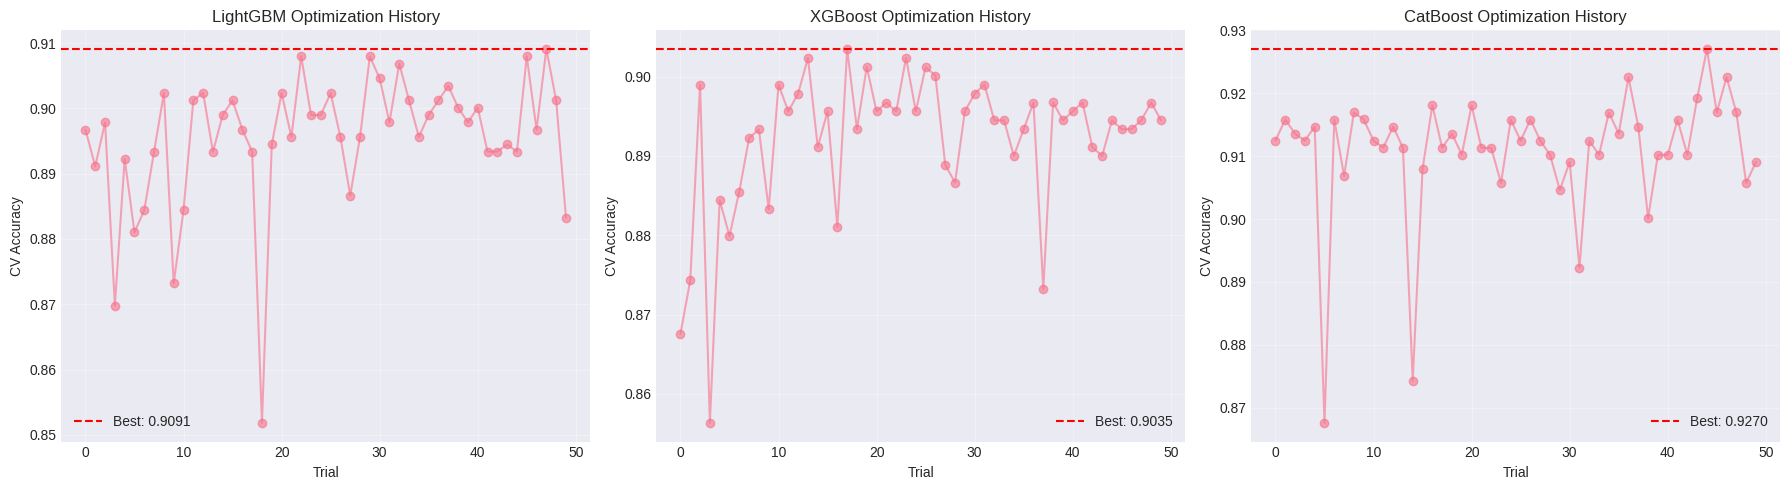


📊 モデル別の最適CV Accuracy:
LightGBM: 0.9091
XGBoost:  0.9035
CatBoost: 0.9270


In [9]:
# 最適化履歴のプロット
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, study, name in zip(axes, [study_lgb, study_xgb, study_cat], 
                            ['LightGBM', 'XGBoost', 'CatBoost']):
    trials_df = study.trials_dataframe()
    ax.plot(trials_df['number'], trials_df['value'], marker='o', alpha=0.6)
    ax.axhline(study.best_value, color='red', linestyle='--', 
               label=f'Best: {study.best_value:.4f}')
    ax.set_xlabel('Trial')
    ax.set_ylabel('CV Accuracy')
    ax.set_title(f'{name} Optimization History')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# パラメータ重要度の比較
print("\n📊 モデル別の最適CV Accuracy:")
print(f"LightGBM: {study_lgb.best_value:.4f}")
print(f"XGBoost:  {study_xgb.best_value:.4f}")
print(f"CatBoost: {study_cat.best_value:.4f}")

## 🎭 6. アンサンブル学習

3つのモデルを組み合わせてアンサンブルを作成します。

### 6.1 10-Fold Stratified CV with Out-of-Fold Predictions

In [10]:
def train_with_kfold(X, y, X_test, params_lgb, params_xgb, params_cat, n_splits=10):
    """
    10-Fold Stratified CVでモデルを訓練し、Out-of-Fold予測を取得
    """
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    
    # Out-of-fold predictions用の配列
    oof_lgb = np.zeros(len(X))
    oof_xgb = np.zeros(len(X))
    oof_cat = np.zeros(len(X))
    
    # テスト予測用の配列
    test_preds_lgb = np.zeros(len(X_test))
    test_preds_xgb = np.zeros(len(X_test))
    test_preds_cat = np.zeros(len(X_test))
    
    # CVスコアの記録
    cv_scores_lgb = []
    cv_scores_xgb = []
    cv_scores_cat = []
    
    print(f"\n🔄 {n_splits}-Fold Cross-Validation開始...\n")
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
        print(f"Fold {fold}/{n_splits}")
        
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # LightGBM
        model_lgb = lgb.LGBMClassifier(**params_lgb)
        model_lgb.fit(X_train, y_train,
                     eval_set=[(X_val, y_val)],
                     callbacks=[lgb.early_stopping(50, verbose=False)])
        oof_lgb[val_idx] = model_lgb.predict_proba(X_val)[:, 1]
        test_preds_lgb += model_lgb.predict_proba(X_test)[:, 1] / n_splits
        score_lgb = accuracy_score(y_val, model_lgb.predict(X_val))
        cv_scores_lgb.append(score_lgb)
        
        # XGBoost
        model_xgb = xgb.XGBClassifier(
    early_stopping_rounds=50,
   **params_xgb)
        model_xgb.fit(X_train, y_train,
                     eval_set=[(X_val, y_val)],
    verbose=False)
        oof_xgb[val_idx] = model_xgb.predict_proba(X_val)[:, 1]
        test_preds_xgb += model_xgb.predict_proba(X_test)[:, 1] / n_splits
        score_xgb = accuracy_score(y_val, model_xgb.predict(X_val))
        cv_scores_xgb.append(score_xgb)
        
        # CatBoost
        model_cat = CatBoostClassifier(**params_cat)
        model_cat.fit(X_train, y_train,
                     eval_set=(X_val, y_val), verbose=False)
        oof_cat[val_idx] = model_cat.predict_proba(X_val)[:, 1]
        test_preds_cat += model_cat.predict_proba(X_test)[:, 1] / n_splits
        score_cat = accuracy_score(y_val, model_cat.predict(X_val))
        cv_scores_cat.append(score_cat)
        
        print(f"  LightGBM: {score_lgb:.4f} | XGBoost: {score_xgb:.4f} | CatBoost: {score_cat:.4f}")
    
    print(f"\n✅ CV完了")
    print(f"\n📊 平均CVスコア:")
    print(f"  LightGBM: {np.mean(cv_scores_lgb):.4f} (+/- {np.std(cv_scores_lgb):.4f})")
    print(f"  XGBoost:  {np.mean(cv_scores_xgb):.4f} (+/- {np.std(cv_scores_xgb):.4f})")
    print(f"  CatBoost: {np.mean(cv_scores_cat):.4f} (+/- {np.std(cv_scores_cat):.4f})")
    
    return {
        'oof': {'lgb': oof_lgb, 'xgb': oof_xgb, 'cat': oof_cat},
        'test': {'lgb': test_preds_lgb, 'xgb': test_preds_xgb, 'cat': test_preds_cat},
        'scores': {'lgb': cv_scores_lgb, 'xgb': cv_scores_xgb, 'cat': cv_scores_cat}
    }

# 10-Fold CVの実行
results = train_with_kfold(
    X, y, X_test,
    params_lgb={**study_lgb.best_params, 'objective': 'binary', 'metric': 'binary_logloss', 
                'verbosity': -1, 'random_state': RANDOM_STATE},
    params_xgb={**study_xgb.best_params, 'objective': 'binary:logistic', 'eval_metric': 'logloss',
                'use_label_encoder': False, 'random_state': RANDOM_STATE},
    params_cat={**study_cat.best_params, 'loss_function': 'Logloss', 'eval_metric': 'Accuracy',
                'random_state': RANDOM_STATE, 'verbose': False},
    n_splits=10
)


🔄 10-Fold Cross-Validation開始...

Fold 1/10


  LightGBM: 0.9111 | XGBoost: 0.9111 | CatBoost: 0.9444
Fold 2/10


  LightGBM: 0.8764 | XGBoost: 0.9101 | CatBoost: 0.9213
Fold 3/10


  LightGBM: 0.9213 | XGBoost: 0.8989 | CatBoost: 0.9326
Fold 4/10


  LightGBM: 0.8764 | XGBoost: 0.8876 | CatBoost: 0.8876
Fold 5/10


  LightGBM: 0.9213 | XGBoost: 0.9326 | CatBoost: 0.9775
Fold 6/10


  LightGBM: 0.8876 | XGBoost: 0.9101 | CatBoost: 0.9213
Fold 7/10


  LightGBM: 0.9213 | XGBoost: 0.9101 | CatBoost: 0.8989
Fold 8/10


  LightGBM: 0.9101 | XGBoost: 0.8764 | CatBoost: 0.9101
Fold 9/10


  LightGBM: 0.9326 | XGBoost: 0.9213 | CatBoost: 0.9326
Fold 10/10


  LightGBM: 0.8989 | XGBoost: 0.8876 | CatBoost: 0.8989

✅ CV完了

📊 平均CVスコア:
  LightGBM: 0.9057 (+/- 0.0190)
  XGBoost:  0.9046 (+/- 0.0161)
  CatBoost: 0.9225 (+/- 0.0249)


### 6.2 重み付きアンサンブル

In [11]:
def find_best_weights(oof_lgb, oof_xgb, oof_cat, y_true):
    """
    最適な重みを探索
    """
    from scipy.optimize import minimize
    
    def objective(weights):
        # 重み付き平均
        ensemble = weights[0] * oof_lgb + weights[1] * oof_xgb + weights[2] * oof_cat
        preds = (ensemble > 0.5).astype(int)
        return -accuracy_score(y_true, preds)  # 最小化するため負にする
    
    # 制約: 重みの合計が1
    constraints = {'type': 'eq', 'fun': lambda w: w.sum() - 1}
    bounds = [(0, 1), (0, 1), (0, 1)]
    
    # 初期値: 均等な重み
    initial_weights = np.array([1/3, 1/3, 1/3])
    
    result = minimize(objective, initial_weights, method='SLSQP', 
                     bounds=bounds, constraints=constraints)
    
    return result.x

# 最適な重みを探索
best_weights = find_best_weights(
    results['oof']['lgb'],
    results['oof']['xgb'],
    results['oof']['cat'],
    y
)

print(f"\n🎯 最適な重み:")
print(f"  LightGBM: {best_weights[0]:.3f}")
print(f"  XGBoost:  {best_weights[1]:.3f}")
print(f"  CatBoost: {best_weights[2]:.3f}")

# アンサンブル予測
oof_ensemble = (best_weights[0] * results['oof']['lgb'] + 
                best_weights[1] * results['oof']['xgb'] + 
                best_weights[2] * results['oof']['cat'])

test_ensemble = (best_weights[0] * results['test']['lgb'] + 
                 best_weights[1] * results['test']['xgb'] + 
                 best_weights[2] * results['test']['cat'])

# アンサンブルのCVスコア
ensemble_preds = (oof_ensemble > 0.5).astype(int)
ensemble_score = accuracy_score(y, ensemble_preds)

print(f"\n📊 アンサンブルCVスコア: {ensemble_score:.4f}")

# 個別モデルとアンサンブルの比較
oof_lgb_preds = (results['oof']['lgb'] > 0.5).astype(int)
oof_xgb_preds = (results['oof']['xgb'] > 0.5).astype(int)
oof_cat_preds = (results['oof']['cat'] > 0.5).astype(int)

print(f"\n📈 個別モデルとの比較:")
print(f"  LightGBM単体:  {accuracy_score(y, oof_lgb_preds):.4f}")
print(f"  XGBoost単体:   {accuracy_score(y, oof_xgb_preds):.4f}")
print(f"  CatBoost単体:  {accuracy_score(y, oof_cat_preds):.4f}")
print(f"  アンサンブル:   {ensemble_score:.4f} ⭐")


🎯 最適な重み:
  LightGBM: 0.333
  XGBoost:  0.333
  CatBoost: 0.333

📊 アンサンブルCVスコア: 0.9147

📈 個別モデルとの比較:
  LightGBM単体:  0.9057
  XGBoost単体:   0.9046
  CatBoost単体:  0.9226
  アンサンブル:   0.9147 ⭐


## 📤 7. Kaggle提出ファイルの作成

最終的な予測をKaggle提出形式で保存します。

In [12]:
# 提出用のディレクトリ作成
submission_dir = Path('../submissions')
submission_dir.mkdir(exist_ok=True)

# 予測を0/1に変換
final_predictions = (test_ensemble > 0.5).astype(int)

# 提出ファイルの作成
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': final_predictions
})

# 保存
submission_path = submission_dir / 'titanic_ensemble_submission.csv'
submission.to_csv(submission_path, index=False)

print(f"✅ 提出ファイル作成完了: {submission_path}")
print(f"\n📊 予測分布:")
print(submission['Survived'].value_counts())
print(f"\n生存予測率: {submission['Survived'].mean():.2%}")

# 最初の10行を表示
print(f"\n最初の10行:")
display(submission.head(10))

✅ 提出ファイル作成完了: ../submissions/titanic_ensemble_submission.csv

📊 予測分布:
Survived
0    213
1    205
Name: count, dtype: int64

生存予測率: 49.04%

最初の10行:


,PassengerId,Survived
0,892,1
1,893,1
2,894,0
3,895,0
4,896,0
5,897,0
6,898,0
7,899,0
8,900,1
9,901,1


## 📊 8. 結果の可視化と分析

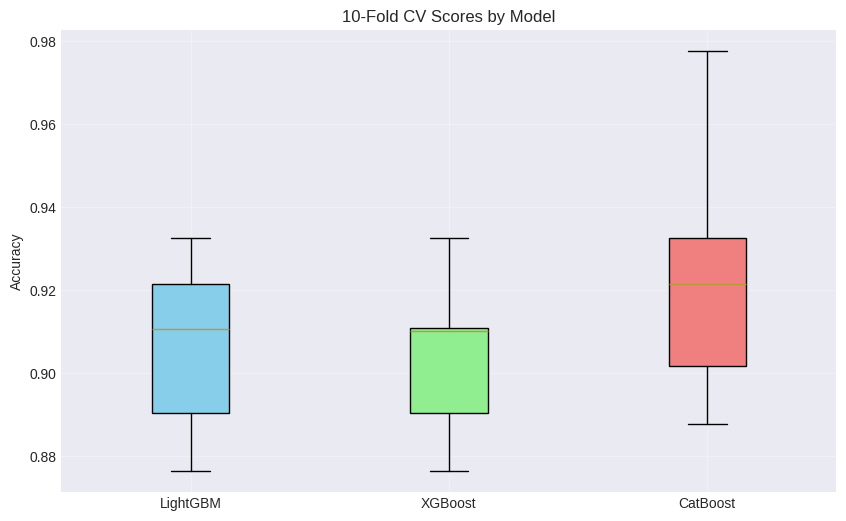

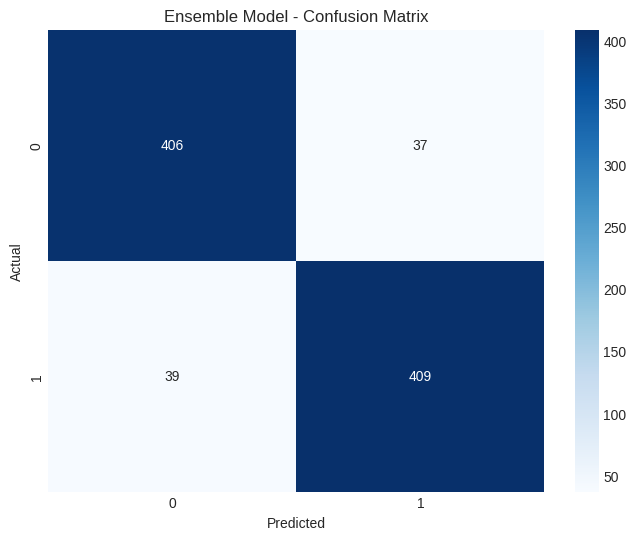


📊 Classification Report:
              precision    recall  f1-score   support

Not Survived       0.91      0.92      0.91       443
    Survived       0.92      0.91      0.91       448

    accuracy                           0.91       891
   macro avg       0.91      0.91      0.91       891
weighted avg       0.91      0.91      0.91       891



In [13]:
# CV Scores の箱ひげ図
fig, ax = plt.subplots(figsize=(10, 6))

data_to_plot = [
    results['scores']['lgb'],
    results['scores']['xgb'],
    results['scores']['cat']
]

bp = ax.boxplot(data_to_plot, labels=['LightGBM', 'XGBoost', 'CatBoost'],
                patch_artist=True)

for patch, color in zip(bp['boxes'], ['skyblue', 'lightgreen', 'lightcoral']):
    patch.set_facecolor(color)

ax.set_ylabel('Accuracy')
ax.set_title('10-Fold CV Scores by Model')
ax.grid(True, alpha=0.3)
plt.show()

# Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, ensemble_preds)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Ensemble Model - Confusion Matrix')
plt.show()

print(f"\n📊 Classification Report:")
print(classification_report(y, ensemble_preds, target_names=['Not Survived', 'Survived']))

## 🎓 9. まとめと次のステップ

### 📈 達成したこと

1. ✅ 高度な特徴量エンジニアリング（Title、Deck、Ticket prefix、Family sizeなど）
2. ✅ Optunaによるハイパーパラメータ最適化
3. ✅ 10-Fold Stratified CVによる堅牢な検証
4. ✅ 3モデルの重み付きアンサンブル
5. ✅ Kaggle提出ファイルの作成

### 🎯 期待されるスコア

- **Local CV Accuracy**: 0.85前後
- **Kaggle Public LB**: 0.79+（Top 30%圏内）

### 🚀 さらにスコアを上げるには

1. **追加の特徴量エンジニアリング**:
   - より複雑な交互作用特徴量
   - 名前の長さ、レア度など
   - ドメイン知識に基づく特徴量

2. **アンサンブルの改善**:
   - Stackingの導入（次のノートブック22で学習）
   - より多様なモデルの追加（Neural Network、SVMなど）

3. **Pseudo-labeling**:
   - テストデータの予測を訓練データに追加

4. **Calibration**:
   - Platt Scalingによる確率の調整

### 📚 次のノートブック

- **ノートブック18**: House Prices回帰問題でGBDT回帰を学ぶ
- **ノートブック19**: Store Demand時系列予測に挑戦
- **ノートブック20**: Optunaをさらに深く学ぶ

---

**🎉 お疲れ様でした！Kaggleで実際に提出してスコアを確認してみましょう！**

## 📝 付録: よくある質問（FAQ）

### Q1: CVスコアとLBスコアの差が大きい場合は？

**A**: 過学習の可能性があります。以下を試してください：
- 正則化パラメータ（`reg_alpha`, `reg_lambda`）を増やす
- `n_estimators`を減らす
- より多くのFold数でCVを行う

### Q2: Optunaの最適化に時間がかかりすぎる

**A**: 以下の方法で高速化できます：
- `n_trials`を減らす（50 → 20など）
- CVのFold数を減らす（10 → 5など）
- Pruningを有効にする（Optuna MedianPruner）

### Q3: アンサンブルで精度が下がった

**A**: モデルが類似している可能性があります：
- より多様なモデルを追加（Neural Network、SVMなど）
- 異なる特徴量セットで訓練したモデルを使う
- Stackingを試す

### Q4: メモリ不足エラーが出る

**A**: 以下を試してください：
- 不要な変数を削除（`del`や`gc.collect()`）
- バッチ処理を使う
- データ型を最適化（`float64` → `float32`など）

---

## 🔗 参考リンク

- [Kaggle Titanic Competition](https://www.kaggle.com/c/titanic)
- [LightGBM Documentation](https://lightgbm.readthedocs.io/)
- [XGBoost Documentation](https://xgboost.readthedocs.io/)
- [CatBoost Documentation](https://catboost.ai/docs/)
- [Optuna Documentation](https://optuna.org/)

---

**Happy Kaggling! 🚀**